<br>

<br>

# This next cell contains methods for generating data for training the feature extractor and data for environments 1, 2, and 3 by adding color to the MNIST images and binarizing the image labels.

In [1]:

import numpy as np
import struct
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import torch
from torchvision import datasets
from torch import nn, optim, autograd
import pandas as pd
from numpy import vstack
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import accuracy_score
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torch.utils.data import DataLoader
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import Adam
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from scipy import stats



# Download and split MNIST data
mnist = datasets.MNIST('~/datasets/mnist', train=True, download=True)
mnist_train = (mnist.data[:40000], mnist.targets[:40000])
mnist_test = (mnist.data[40000:], mnist.targets[40000:])
mnist_all = (mnist.data, mnist.targets)

#Shuffle the data
rng_state = np.random.get_state()
np.random.shuffle(mnist_train[0].numpy())
np.random.set_state(rng_state)
np.random.shuffle(mnist_train[1].numpy())

rng_state = np.random.get_state()
np.random.shuffle(mnist_all[0].numpy())
np.random.set_state(rng_state)
np.random.shuffle(mnist_all[1].numpy())

# Splitting the data that will be used to train the feature extractor 
# into 80% train set and 20% test set
X_train = mnist_all[0][:int(0.8*len(mnist_all[0]))] 
y_train = mnist_all[1][:int(0.8*len(mnist_all[1]))] 
X_test = mnist_all[0][int(0.8*len(mnist_all[0])):]
y_test = mnist_all[1][int(0.8*len(mnist_all[1])):]


# used to binarize the target variable
def binarize(y, label_noise=0.):
    
    y = np.copy(y) > 4
    
    if label_noise > 0:
        y = np.logical_xor(y, np.random.binomial(1, label_noise, size=len(y)))
    
    return y.astype(int)

# used to randomly add color to the dataset used to train the feature extractor
def color_digits(X, y, color_noise=None, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
    
    if color_noise is None:
        color = np.random.choice([True, False], size=len(y))
    else:
        color = np.logical_xor(y, np.random.binomial(1, color_noise, size=len(y)))
    colored_X = np.repeat(X[:,None,:,:],2,axis=1)
    colored_X[color,0,:,:] = 0
    colored_X[~color,1,:,:] = 0    
    colored_X = colored_X.reshape(X.shape[0],-1)    
    return (colored_X.astype(float)/ 255.), color.astype(int)



# used to color either the entire dataset green or the entire dataset red
def color_all_images_same_color(X, green=True, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
        
    if green:
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,0,:,:] = 0
    else:
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,1,:,:] = 0
   
    colored_X = colored_X.reshape(X.shape[0],-1)    
    return (colored_X.astype(float)/ 255.)


# Produce images for the factor model
def produce_images_for_the_factor_model(X, green=True, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
    color = None    
    if green:
        color = np.ones(len(X))
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,0,:,:] = 0
    else:
        color = np.zeros(len(X))
        colored_X = np.repeat(X[:,None,:,:],2,axis=1)
        colored_X[:,1,:,:] = 0
   
    colored_X = colored_X.reshape(X.shape[0],-1)    
    return (colored_X.astype(float)/ 255.), color.astype(int)


# Used to generate environments 1, 2, and 3 by varying the distribution of color
def generate_environments(X, y, color_noise=None, downsample=True):    
    if downsample:
        X = np.copy(X)[:,::2,::2]
    
    if color_noise is None:
        color = np.random.choice([True, False], size=len(y))
    else:
        color = np.logical_xor(y, np.random.binomial(1, color_noise, size=len(y)))
    colored_X = np.repeat(X[:,None,:,:],2,axis=1)
    colored_X[color,0,:,:] = 0
    colored_X[~color,1,:,:] = 0
    
    colored_X = colored_X.reshape(X.shape[0],-1)
    
    return {
      'images': (colored_X.astype(float) / 255.),
      'labels': y[:, None],
      'colors': color[:, None]
    }

    
    
# Used to plot colored images    
def plot_images(X, n_row=10, n_col=10, shape=(2,14,14), scale=False):
    fig = plt.figure(figsize=(n_row, n_col))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(n_row, n_col),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )
    for ax in grid:
        index = np.random.choice(np.arange(X.shape[0]))
        img = X[index].reshape(shape)
        if scale:
            img = img - img.min()
            img /= img.max()
        img = np.vstack((img, np.zeros((1,shape[1],shape[2]))))
        img = np.moveaxis(img, 0, -1)
        ax.imshow(img)
        ax.set_axis_off()
    plt.show()
    return

<br>

# Define, train, and evaluate the feature extractor

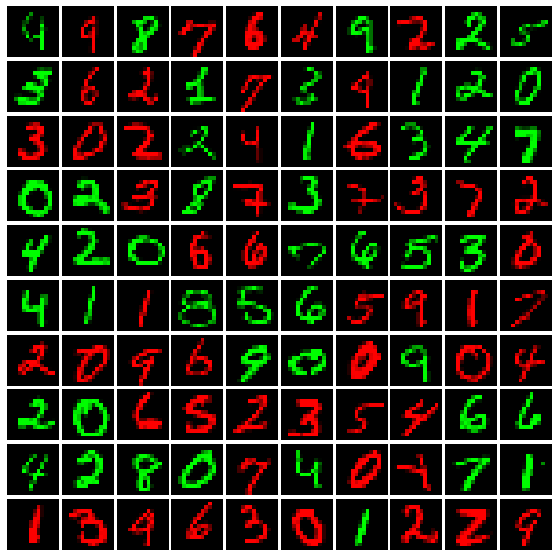

Sequential(
  (0): Linear(in_features=392, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=2, bias=True)
)
Label Accuracy:  0.9464166666666667
Color Accuracy:  1.0


In [2]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

class MLP(torch.nn.Module):

    def __init__(self, size=[2*14*14, 2]):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(size)-2):
            layers.append(torch.nn.Linear(size[i], size[i+1]))
            layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Linear(size[-2], size[-1]))
        self.net = torch.nn.Sequential(*layers)
        print(self.net)

    def forward(self, x):
        return self.net(x)

def tensor_numpy(arrays, device):
    out = []
    for a in arrays:
        out.append(torch.from_numpy(a).float().to(device))
    return out
    
    
np.random.seed(1)
label_noise = 0.
color_noise = None

y_train = binarize(y_train, label_noise=label_noise)
y_test = binarize(y_test, label_noise=label_noise)

X_train, color_train = color_digits(X_train, y_train, color_noise, downsample=True)
X_test, color_test = color_digits(X_test, y_test, color_noise, downsample=True)

plot_images(X_train)
# plot_images(X_test)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

hidden_size = [2*14*14, 50, 2]
net = MLP(hidden_size).to(device)

tr_x, tr_y, tr_c = tensor_numpy([X_train, y_train, color_train], device)
te_x, te_y, te_c = tensor_numpy([X_test, y_test, color_test], device)

bs = 256

tr_dataset = TensorDataset(tr_x, tr_y, tr_c)
tr_loader = DataLoader(tr_dataset, batch_size = bs, shuffle = True)
# te_dataset = TensorDataset(te_x, te_y, te_c)
# te_loader = DataLoader(te_dataset, batch_size = bs, shuffle = True)

loss_label = torch.nn.BCEWithLogitsLoss()
loss_color = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)

epoch = 10
for e in range(epoch):
    
    for x, y, c in tr_loader:
        
        optimizer.zero_grad()
        
        out = net(x)
        loss_y = loss_label(out[:,0], y)
        loss_c = loss_color(out[:,1], c)
        loss = loss_y + loss_c
        
        loss.backward()
        optimizer.step()
        
            
with torch.no_grad():
    test_preds = 1*(net(te_x).detach().cpu().numpy()>0)
#     acc_y = (test_preds[:,0] == y_test).mean()
#     acc_c = (test_preds[:,1] == color_test).mean()
    acc_y = accuracy_score(y_test, test_preds[:,0])
    acc_c = accuracy_score(color_test, test_preds[:,1])
    print('Label Accuracy: ', acc_y)
    print('Color Accuracy: ', acc_c)

<br>

# Use the trained feature extractor to extract features from data that will be used to train and test our classifiers

In [3]:
label_noise = 0.
color_noise = None


env1_X_train = mnist_train[0][::2]
env1_y_train = binarize(mnist_train[1][::2], label_noise=label_noise)

env2_X_train = mnist_train[0][1::2]
env2_y_train = binarize(mnist_train[1][1::2], label_noise=label_noise)

env3_X_train = mnist_test[0]
env3_y_train = binarize(mnist_test[1], label_noise=label_noise)

envs = [
generate_environments(env1_X_train, env1_y_train, 0.1),
generate_environments(env2_X_train, env2_y_train, 0.05),
generate_environments(env3_X_train, env3_y_train, 0.9)
]


class feature_extractor(nn.Module):
    def __init__(self):
        super().__init__()   
        net.eval()
        self.children_list = []
        for n,c in net.named_children():
            self.children_list.append(c)
            
        print("Printing all the trained model layers")
        print(self.children_list)
        self.children_list = self.children_list[0][:2]
        print("Printing model layers after dropping the output layer for feature extraction")    
        print(self.children_list)
        self.net = nn.Sequential(*self.children_list)
        self.pretrained = None
        
    def forward(self,x):
        x = self.net(x)
        return x


def extract_features(model,x,y, device = 'cpu'):
    extracted_features = []
    labels = []   
    with torch.no_grad():
        x = x.to(device)
        extracted_features = model(x.float())
    extracted_features = torch.flatten(extracted_features, 1)
    extracted_features_df = pd.DataFrame(extracted_features.numpy())
    extracted_features_df["target"] = y.cpu().numpy()
    return extracted_features_df



train_envs_1_and_2_inputs = torch.cat((torch.from_numpy(envs[0]['images']), torch.from_numpy(envs[1]['images'])), 0)
train_envs_1_and_2_targets = torch.cat((torch.from_numpy(envs[0]['labels']), torch.from_numpy(envs[1]['labels'])), 0)

print("Combined environments 1 and 2 data size - used to train our final prediction models")
print(len(train_envs_1_and_2_inputs))
print(len(train_envs_1_and_2_targets))

test_inputs =torch.from_numpy(envs[2]['images'])
test_targets =torch.from_numpy(envs[2]['labels'])

print("Environment 3 data size - used to test our final prediction models")
print(len(test_inputs))
print(len(test_targets))

feature_extractor = feature_extractor()

train_extracted_features_df = extract_features(feature_extractor,train_envs_1_and_2_inputs, train_envs_1_and_2_targets)
test_extracted_features_df = extract_features(feature_extractor,test_inputs, test_targets)


print("Printing the extracted features - first train features followed by test features shape/size!!!")
# print(train_extracted_features_df)
print(train_extracted_features_df.shape)
# print(test_extracted_features_df)
print(test_extracted_features_df.shape)


Combined environments 1 and 2 data size - used to train our final prediction models
40000
40000
Environment 3 data size - used to test our final prediction models
20000
20000
Printing all the trained model layers
[Sequential(
  (0): Linear(in_features=392, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=2, bias=True)
)]
Printing model layers after dropping the output layer for feature extraction
Sequential(
  (0): Linear(in_features=392, out_features=50, bias=True)
  (1): ReLU()
)
Printing the extracted features - first train features followed by test features shape/size!!!
(40000, 51)
(20000, 51)


In [4]:
# envs = [
# generate_environments(env1_X_train, env1_y_train, 0.2),
# generate_environments(env2_X_train, env2_y_train, 0.4),
# generate_environments(env3_X_train, env3_y_train, 0.9)
# ]

<br>

<br>

# Transforming the extracted image features using a factor model

# Preparing the features that we will need to obtain F and L for.

All images colored green
Color labels for green:
[1 1 1 ... 1 1 1]


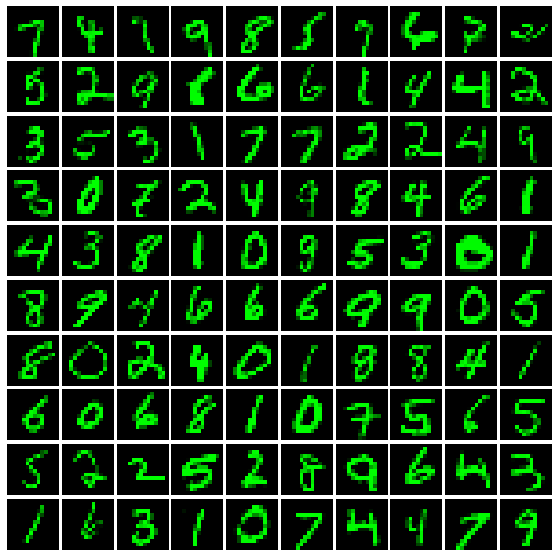

All images colored red
Color labels for red:
[0 0 0 ... 0 0 0]


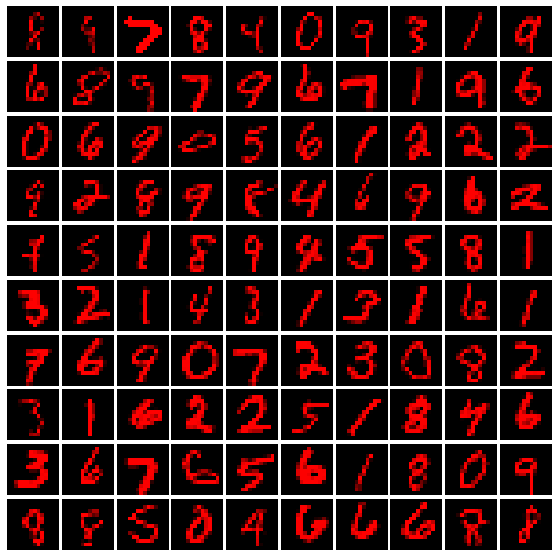

Z shape
(96000, 50)
Z_test shape
(24000, 50)
Z_test_green shape
(12000, 50)
Z_test_red shape
(12000, 50)


In [5]:
X_train_ = mnist_all[0][:int(0.8*len(mnist_all[0]))] 
y_train_ = mnist_all[1][:int(0.8*len(mnist_all[1]))]

X_test_ = mnist_all[0][int(0.8*len(mnist_all[0])):]
y_test_ = mnist_all[1][int(0.8*len(mnist_all[1])):]

y_train_ = binarize(y_train_, label_noise=label_noise)
y_test_ = binarize(y_test_, label_noise=label_noise)

green_images, color_green = produce_images_for_the_factor_model(X_train_, green=True)

red_images, color_red = produce_images_for_the_factor_model(X_train_, green=False)

green_and_red_images = np.concatenate((green_images, red_images), axis=0)
color = np.concatenate((color_green, color_red), axis=None)
label_train = np.concatenate((y_train_, y_train_), axis=None)
    



green_images_test, color_green_test = produce_images_for_the_factor_model(X_test_, green=True)

red_images_test, color_red_test = produce_images_for_the_factor_model(X_test_, green=False)

green_and_red_images_test = np.concatenate((green_images_test, red_images_test), axis=0)
color_test = np.concatenate((color_green_test, color_red_test), axis=None)
label_test = np.concatenate((y_test_, y_test_), axis=None)




print("All images colored green")
print("Color labels for green:")
print(color_green)
plot_images(green_images)


print("All images colored red")
print("Color labels for red:")
print(color_red)
plot_images(red_images)


# extract features from green and red train images
Z = extract_features(feature_extractor,torch.from_numpy(green_and_red_images), 
                                        torch.from_numpy(color)).to_numpy()[:, :-1]



# extract features from green and red test images
Z_test = extract_features(feature_extractor,torch.from_numpy(green_and_red_images_test), 
                                        torch.from_numpy(color_test)).to_numpy()[:, :-1]


# extract features from green test images
Z_test_green = extract_features(feature_extractor,torch.from_numpy(green_images_test), 
                                        torch.from_numpy(color_green_test)).to_numpy()[:, :-1]

# extract features from red test images
Z_test_red = extract_features(feature_extractor,torch.from_numpy(red_images_test), 
                                        torch.from_numpy(color_red_test)).to_numpy()[:, :-1]

# Features from images in environments 1, 2, and 3. Environments 1 and 2 are combined to be used for training. 
Z_envs_1_and_2 = train_extracted_features_df.to_numpy()[:, :-1]
Z_env3 = test_extracted_features_df.to_numpy()[:, :-1]


print("Z shape")
print(Z.shape)

print("Z_test shape")
print(Z_test.shape)

print("Z_test_green shape")
print(Z_test_green.shape)

print("Z_test_red shape")
print(Z_test_red.shape)


# Findind L using a closed form solution

## Obtaining color coefficients

In [6]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression


lr_model = LogisticRegression(random_state=0).fit(Z, color)

color_coefficients = lr_model.coef_.reshape(-1,1)
color_coefficients = color_coefficients / np.linalg.norm(color_coefficients)

print("Printing color coefficients")
print(color_coefficients)
print()
print("Color coefficients shape")
print(color_coefficients.shape)

Printing color coefficients
[[ 0.10853906]
 [-0.21126029]
 [-0.05900388]
 [-0.12386781]
 [ 0.11757678]
 [-0.14442293]
 [ 0.0532459 ]
 [ 0.15776129]
 [ 0.36799333]
 [ 0.14489317]
 [ 0.09382452]
 [-0.14491936]
 [ 0.21009398]
 [ 0.01116186]
 [-0.09184869]
 [ 0.11755651]
 [ 0.11698817]
 [ 0.04999702]
 [ 0.18083669]
 [-0.05533426]
 [ 0.2864974 ]
 [-0.2642209 ]
 [ 0.06171588]
 [ 0.09270417]
 [-0.03456552]
 [-0.12011035]
 [-0.01971781]
 [ 0.04670436]
 [ 0.12524285]
 [-0.13429296]
 [ 0.09922784]
 [ 0.05874576]
 [-0.16565751]
 [-0.13927981]
 [-0.11898544]
 [-0.14111187]
 [-0.1727782 ]
 [ 0.11258712]
 [ 0.02481863]
 [ 0.175669  ]
 [ 0.08514372]
 [ 0.08088264]
 [-0.07735477]
 [-0.20495595]
 [ 0.08892848]
 [-0.07995684]
 [-0.18405937]
 [-0.08611997]
 [ 0.23624797]
 [ 0.00766793]]

Color coefficients shape
(50, 1)


## Computing M

In [7]:
lamda = 0.01

k = int(Z.shape[1]*0.2) # 20% of original number of features
n = Z.shape[0]


# the difference between Z_green and Z_red in Z
# delta_Z_matrix = (Z[:int(len(color)/2),:] - Z[int(len(color)/2):,:])
delta_Z_matrix = np.absolute((Z[:int(len(color)/2),:] - Z[int(len(color)/2):,:]))

M = - Z.T @ Z/n + lamda * delta_Z_matrix.T @ delta_Z_matrix / (n // 2 ) 
#n M = p.matmul(-Z.transpose(), Z) -   lamda * (Z.transpose() @ Z@ delta_Z_matrix.transpose() @ delta_Z_matrix)
# M = np.matmul(-Z.transpose(), Z) +   lamda * (Z.transpose() @ Z@ delta_Z_matrix.transpose() @ delta_Z_matrix)
# M = np.matmul(-Z.transpose(), Z)/n +   lamda * (Z.transpose() @ Z@ delta_Z_matrix.transpose() @ delta_Z_matrix)/(n // 2 )
M.shape

(50, 50)

## Computing the term on which we will perform SVD

In [8]:
alpha_alpha_T = color_coefficients @ color_coefficients.T
d = alpha_alpha_T.shape[0]
I = np.identity(d)
I_minus_alpa_alpha_T = I-alpha_alpha_T
term_for_SVD = (I_minus_alpa_alpha_T @ M) @ I_minus_alpa_alpha_T
term_for_SVD

array([[-2.60482853, -2.86118882, -0.95001381, ..., -2.39331169,
        -1.90209131, -1.11985643],
       [-2.86118882, -3.96010626, -1.28481615, ..., -3.12557462,
        -2.47348726, -1.54643192],
       [-0.95001381, -1.28481615, -1.02670869, ..., -1.0041526 ,
        -0.84890655, -0.54886277],
       ...,
       [-2.39331169, -3.12557462, -1.0041526 , ..., -3.11896708,
        -1.98989994, -1.28625725],
       [-1.90209131, -2.47348726, -0.84890655, ..., -1.98989994,
        -1.84755222, -1.08402922],
       [-1.11985643, -1.54643192, -0.54886277, ..., -1.28625725,
        -1.08402922, -1.10918732]])

## Performing SVD to get eigenvectors and eigenvalues

In [9]:
from numpy import linalg as LA
eigenvalues, eigenvectors = LA.eigh(term_for_SVD)
display(eigenvalues)
display(eigenvectors)
display(eigenvectors.shape)

array([-1.03062506e+02, -3.99659834e+00, -2.68476352e+00, -2.38875546e+00,
       -1.95753161e+00, -1.46047587e+00, -1.35130374e+00, -1.10489958e+00,
       -9.06365202e-01, -6.72269352e-01, -6.45071076e-01, -4.35648622e-01,
       -3.18841327e-01, -2.79829241e-01, -2.59771186e-01, -2.36706655e-01,
       -2.13990495e-01, -1.36075764e-01, -1.25685822e-01, -1.02791737e-01,
       -9.04876690e-02, -8.40597602e-02, -7.77436297e-02, -6.86469673e-02,
       -6.52121028e-02, -5.80173924e-02, -5.67829727e-02, -4.64605240e-02,
       -4.23941516e-02, -3.26964863e-02, -3.00646694e-02, -2.78946667e-02,
       -2.49104562e-02, -2.14902841e-02, -1.99216419e-02, -1.94272380e-02,
       -1.73183796e-02, -1.57015565e-02, -1.27076034e-02, -1.10820423e-02,
       -9.16377964e-03, -8.11333959e-03, -7.71893225e-03, -7.38412359e-03,
       -6.47888998e-03, -5.97321462e-03, -4.78224014e-03, -3.38695547e-03,
        1.67220661e-16,  2.79645413e-02])

array([[-0.14639698,  0.06874706,  0.00244797, ..., -0.01745149,
         0.10853906, -0.11131054],
       [-0.18818578,  0.05796067, -0.11542727, ..., -0.01879929,
        -0.21126029,  0.02737658],
       [-0.06317903, -0.00915894, -0.07360334, ..., -0.0264962 ,
        -0.05900388,  0.13081726],
       ...,
       [-0.1565295 ,  0.13537417, -0.3211581 , ...,  0.12355462,
        -0.08611997, -0.27510702],
       [-0.13030809, -0.10900669,  0.05455492, ...,  0.6210164 ,
         0.23624797,  0.19048393],
       [-0.07877894, -0.16103214, -0.08788896, ..., -0.01362807,
         0.00766793, -0.11549839]])

(50, 50)

## Forming L from the eigen vectors and alpha

In [10]:
L_1 = color_coefficients
# L_2 = eigenvectors[:,(eigenvectors.shape[1]-k):eigenvectors.shape[1]-1]

least_k_eigen_values = eigenvalues[:k]


least_k_eigen_values[np.absolute(least_k_eigen_values)<0.000001]=0

print("Printing least k eigenvalues before removing the zero eigenvalue")
print(least_k_eigen_values)

non_zero_indeces = None
if 0 in least_k_eigen_values:
    non_zero_indeces = np.nonzero(least_k_eigen_values)[0]
    least_k_eigen_values_without_0 = least_k_eigen_values[non_zero_indeces]
    print("Printing least k eigenvalues after removing the zero eigenvalue")
    print(least_k_eigen_values_without_0)
    
else:
    non_zero_indeces = np.nonzero(least_k_eigen_values[:k-1])[0]
    least_k_eigen_values_without_0 = least_k_eigen_values[:k-1]
    print("Printing least k eigenvalues after removing the zero eigenvalue")
    print(least_k_eigen_values_without_0)

print("Printing non zero indeces of the least k eigenvalues") 
print(non_zero_indeces) #

L_2 = eigenvectors[:,non_zero_indeces]

print(L_2.shape)

L = np.concatenate((L_1, L_2), axis=1)

L.shape

Printing least k eigenvalues before removing the zero eigenvalue
[-103.0625063    -3.99659834   -2.68476352   -2.38875546   -1.95753161
   -1.46047587   -1.35130374   -1.10489958   -0.9063652    -0.67226935]
Printing least k eigenvalues after removing the zero eigenvalue
[-103.0625063    -3.99659834   -2.68476352   -2.38875546   -1.95753161
   -1.46047587   -1.35130374   -1.10489958   -0.9063652 ]
Printing non zero indeces of the least k eigenvalues
[0 1 2 3 4 5 6 7 8]
(50, 9)


(50, 10)

# Obtaining F_test values from extracted image features using numpy's linalg.lstsq function.

In [11]:
# Documentation of np.linalg.lstsq: https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html
# F_test = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_test.transpose(), rcond=None)[0].transpose())
# F_test_green = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_test_green.transpose(), rcond=None)[0].transpose())
# F_test_red = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_test_red.transpose(), rcond=None)[0].transpose())

# F_envs_1_and_2 = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_envs_1_and_2.transpose(), rcond=None)[0].transpose())
# F_env3 = torch.from_numpy(np.linalg.lstsq((L.T).detach().numpy(), Z_env3.transpose(), rcond=None)[0].transpose())



F = torch.from_numpy(np.linalg.lstsq(L, Z.transpose(), rcond=None)[0].transpose())
F_test = torch.from_numpy(np.linalg.lstsq(L, Z_test.transpose(), rcond=None)[0].transpose())
F_test_green = torch.from_numpy(np.linalg.lstsq(L, Z_test_green.transpose(), rcond=None)[0].transpose())
F_test_red = torch.from_numpy(np.linalg.lstsq(L, Z_test_red.transpose(), rcond=None)[0].transpose())

F_envs_1_and_2 = torch.from_numpy(np.linalg.lstsq(L, Z_envs_1_and_2.transpose(), rcond=None)[0].transpose())
F_env3 = torch.from_numpy(np.linalg.lstsq(L, Z_env3.transpose(), rcond=None)[0].transpose())



print("F_test shape")
print(F_test.shape)

print("F_test_green shape")
print(F_test_green.shape)

print("F_test_red shape")
print(F_test_red.shape)

print("F_envs_1_and_2 shape")
print(F_envs_1_and_2.shape)

print("F_env3 shape")
print(F_env3.shape)


F_test shape
torch.Size([24000, 10])
F_test_green shape
torch.Size([12000, 10])
F_test_red shape
torch.Size([12000, 10])
F_envs_1_and_2 shape
torch.Size([40000, 10])
F_env3 shape
torch.Size([20000, 10])


# Correlation Matrices

## Correlation Matrix for F

In [12]:
pd.DataFrame(torch.corrcoef(F.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.103017,0.772710,-0.013444,-0.029752,-0.083655,0.094207,0.096298,0.213896,-0.363120
1,0.103017,1.000000,0.171713,-0.013707,0.136075,0.262599,-0.107227,0.166728,-0.057543,-0.054218
2,0.772710,0.171713,1.000000,-0.000268,-0.001598,-0.003132,0.000151,-0.001525,0.002452,0.001269
3,-0.013444,-0.013707,-0.000268,1.000000,0.002384,-0.000339,0.001233,0.000157,-0.003178,-0.000470
4,-0.029752,0.136075,-0.001598,0.002384,1.000000,-0.000379,0.000981,-0.001121,-0.001118,-0.000406
5,-0.083655,0.262599,-0.003132,-0.000339,-0.000379,1.000000,0.001852,-0.001696,0.000265,-0.000416
6,0.094207,-0.107227,0.000151,0.001233,0.000981,0.001852,1.000000,-0.001373,-0.007292,-0.002951
7,0.096298,0.166728,-0.001525,0.000157,-0.001121,-0.001696,-0.001373,1.000000,0.003909,0.000331
8,0.213896,-0.057543,0.002452,-0.003178,-0.001118,0.000265,-0.007292,0.003909,1.000000,0.005240
9,-0.363120,-0.054218,0.001269,-0.000470,-0.000406,-0.000416,-0.002951,0.000331,0.005240,1.000000


## Correlation Matrix for F_test

In [13]:
pd.DataFrame(torch.corrcoef(F_test.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.103443,0.771339,-0.028735,-0.018610,-0.089040,0.098148,0.101914,0.221994,-0.378370
1,0.103443,1.000000,0.172130,-0.014633,0.134554,0.263797,-0.107211,0.169373,-0.059121,-0.058137
2,0.771339,0.172130,1.000000,-0.010965,0.002481,-0.010784,0.010323,0.007284,0.000638,-0.011445
3,-0.028735,-0.014633,-0.010965,1.000000,0.008756,-0.004875,0.003567,-0.006643,-0.004529,0.009823
4,-0.018610,0.134554,0.002481,0.008756,1.000000,-0.006799,0.016185,0.002622,-0.007362,-0.012143
5,-0.089040,0.263797,-0.010784,-0.004875,-0.006799,1.000000,-0.004736,-0.003567,-0.010591,-0.001380
6,0.098148,-0.107211,0.010323,0.003567,0.016185,-0.004736,1.000000,-0.004771,0.004943,-0.005620
7,0.101914,0.169373,0.007284,-0.006643,0.002622,-0.003567,-0.004771,1.000000,-0.000778,-0.007481
8,0.221994,-0.059121,0.000638,-0.004529,-0.007362,-0.010591,0.004943,-0.000778,1.000000,-0.011381
9,-0.378370,-0.058137,-0.011445,0.009823,-0.012143,-0.001380,-0.005620,-0.007481,-0.011381,1.000000


## Correlation Matrix for F_test_green

In [14]:
pd.DataFrame(torch.corrcoef(F_test_green.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.866216,0.679717,-0.023241,-0.191293,-0.358606,0.330359,-0.039577,0.289936,-0.046833
1,-0.866216,1.000000,-0.471625,-0.032191,0.250572,0.314213,-0.141457,0.253860,0.054251,0.061376
2,0.679717,-0.471625,1.000000,-0.009728,-0.562109,-0.860423,0.425117,-0.074777,0.186595,0.365130
3,-0.023241,-0.032191,-0.009728,1.000000,-0.206107,-0.018954,-0.297661,0.020369,-0.096813,-0.075713
4,-0.191293,0.250572,-0.562109,-0.206107,1.000000,0.750340,0.263694,-0.064723,0.526091,-0.382512
5,-0.358606,0.314213,-0.860423,-0.018954,0.750340,1.000000,-0.188696,0.237706,0.199081,-0.566298
6,0.330359,-0.141457,0.425117,-0.297661,0.263694,-0.188696,1.000000,-0.399903,0.456351,-0.217195
7,-0.039577,0.253860,-0.074777,0.020369,-0.064723,0.237706,-0.399903,1.000000,0.395469,0.270283
8,0.289936,0.054251,0.186595,-0.096813,0.526091,0.199081,0.456351,0.395469,1.000000,0.093322
9,-0.046833,0.061376,0.365130,-0.075713,-0.382512,-0.566298,-0.217195,0.270283,0.093322,1.000000


## Correlation Matrix for F_test_red

In [15]:
pd.DataFrame(torch.corrcoef(F_test_red.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.945980,0.551311,0.078771,0.116589,0.139627,-0.047438,0.154274,-0.134077,-0.257526
1,0.945980,1.000000,0.565189,0.043378,0.073810,0.240795,-0.116504,0.017704,-0.165241,-0.111570
2,0.551311,0.565189,1.000000,0.076816,0.297361,0.607654,-0.219657,-0.123019,-0.388314,0.309566
3,0.078771,0.043378,0.076816,1.000000,0.475395,0.022104,0.449611,-0.175345,0.210275,0.284405
4,0.116589,0.073810,0.297361,0.475395,1.000000,-0.408433,-0.049315,0.099500,-0.214434,0.242922
5,0.139627,0.240795,0.607654,0.022104,-0.408433,1.000000,0.067306,-0.409919,-0.097728,0.482732
6,-0.047438,-0.116504,-0.219657,0.449611,-0.049315,0.067306,1.000000,0.329637,-0.138543,0.146783
7,0.154274,0.017704,-0.123019,-0.175345,0.099500,-0.409919,0.329637,1.000000,-0.588807,-0.542073
8,-0.134077,-0.165241,-0.388314,0.210275,-0.214434,-0.097728,-0.138543,-0.588807,1.000000,0.065021
9,-0.257526,-0.111570,0.309566,0.284405,0.242922,0.482732,0.146783,-0.542073,0.065021,1.000000


## Correlation Matrix for F_envs_1_and_2

In [16]:
pd.DataFrame(torch.corrcoef(F_envs_1_and_2.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.145123,0.731752,0.477295,0.470656,-0.021975,0.211267,-0.018268,0.406064,-0.321662
1,0.145123,1.000000,0.333364,-0.029480,0.241467,0.213834,-0.135837,0.057930,-0.084848,0.067263
2,0.731752,0.333364,1.000000,0.286064,0.408984,0.278382,-0.065027,-0.063341,0.149118,0.085641
3,0.477295,-0.029480,0.286064,1.000000,0.154843,0.035113,0.161814,-0.210134,0.094929,-0.219059
4,0.470656,0.241467,0.408984,0.154843,1.000000,-0.162985,-0.260565,0.011208,0.079812,-0.195953
5,-0.021975,0.213834,0.278382,0.035113,-0.162985,1.000000,0.078185,-0.228743,-0.125297,0.282041
6,0.211267,-0.135837,-0.065027,0.161814,-0.260565,0.078185,1.000000,0.024867,0.336902,0.046903
7,-0.018268,0.057930,-0.063341,-0.210134,0.011208,-0.228743,0.024867,1.000000,0.272374,0.114764
8,0.406064,-0.084848,0.149118,0.094929,0.079812,-0.125297,0.336902,0.272374,1.000000,0.002289
9,-0.321662,0.067263,0.085641,-0.219059,-0.195953,0.282041,0.046903,0.114764,0.002289,1.000000


## Correlation Matrix for F_env3

In [17]:
pd.DataFrame(torch.corrcoef(F_env3.T).detach().numpy())

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.066324,0.824177,-0.372897,-0.499631,-0.148318,-0.032796,0.187591,0.047377,-0.465310
1,0.066324,1.000000,-0.004933,-0.008315,0.045383,0.328240,-0.076217,0.261612,-0.036867,-0.183542
2,0.824177,-0.004933,1.000000,-0.214748,-0.484278,-0.341436,0.088454,0.045221,-0.147725,-0.173041
3,-0.372897,-0.008315,-0.214748,1.000000,-0.015392,-0.104943,-0.105353,0.138906,-0.076944,0.311518
4,-0.499631,0.045383,-0.484278,-0.015392,1.000000,0.265425,0.268999,-0.022439,-0.070134,0.063584
5,-0.148318,0.328240,-0.341436,-0.104943,0.265425,1.000000,-0.074387,0.245694,0.126229,-0.232318
6,-0.032796,-0.076217,0.088454,-0.105353,0.268999,-0.074387,1.000000,-0.032991,-0.370662,-0.111285
7,0.187591,0.261612,0.045221,0.138906,-0.022439,0.245694,-0.032991,1.000000,-0.208876,-0.150588
8,0.047377,-0.036867,-0.147725,-0.076944,-0.070134,0.126229,-0.370662,-0.208876,1.000000,0.021139
9,-0.465310,-0.183542,-0.173041,0.311518,0.063584,-0.232318,-0.111285,-0.150588,0.021139,1.000000


# Histograms

Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.438054,0.284284,1.926930,1.830961,1.888984,1.104100,0.428722,0.585064,1.242692,0.786670
1,7.417415,0.075891,1.505077,2.073737,2.401787,1.186091,0.238633,0.828356,0.812300,0.718413
2,12.806093,0.742780,3.043204,0.799990,0.986292,0.293867,0.454404,1.065447,1.156592,1.392751
3,12.231457,0.073011,6.272644,1.766879,1.675721,1.729638,2.121818,3.153399,0.715128,1.169403
4,18.430882,2.129327,4.839281,0.828112,0.954383,0.337573,2.302453,2.425044,0.126976,2.464095


Histogram for F Test feature  0


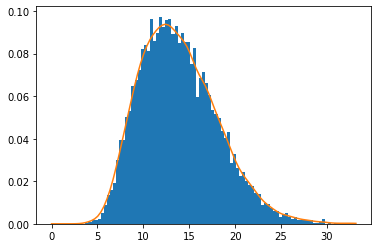

Histogram for F Test feature  1


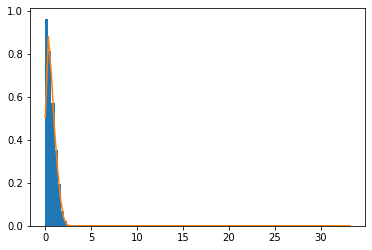

Histogram for F Test feature  2


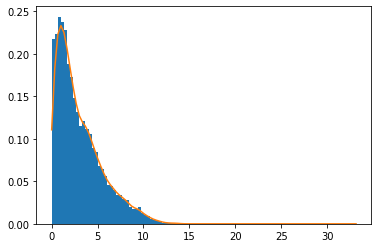

Histogram for F Test feature  3


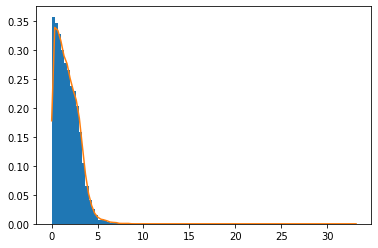

Histogram for F Test feature  4


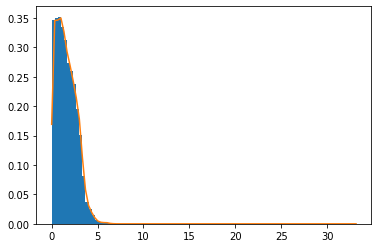

Histogram for F Test feature  5


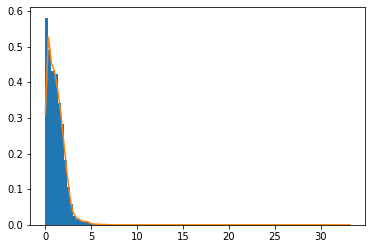

Histogram for F Test feature  6


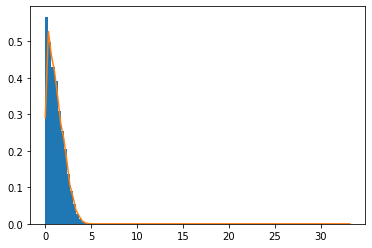

Histogram for F Test feature  7


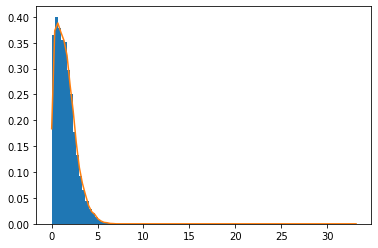

Histogram for F Test feature  8


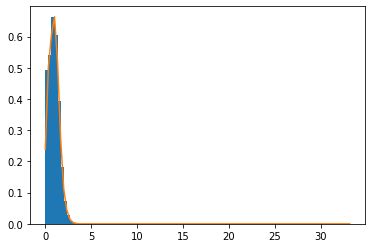

Histogram for F Test feature  9


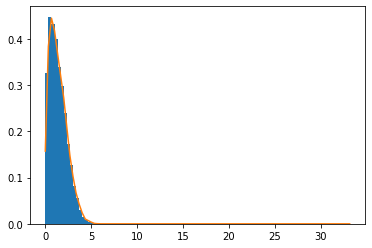

In [18]:
# the difference between F_test_green and F_test_red
delta_matrix = np.absolute(F_test_green.detach().numpy() - F_test_red.detach().numpy())

print("Printing the delta matrix")
delta_matrix_df = pd.DataFrame(delta_matrix)
display(delta_matrix_df.head())

# Plotting the histograms for each feature in the delta matrix # 100 bins
for i in range(len(delta_matrix_df.columns)): 
    print("Histogram for F Test feature ", i)    
    feature = delta_matrix_df.iloc[:,i].values
    density = stats.gaussian_kde(feature)
#     n, x, _ = plt.hist(feature, bins=np.linspace(np.amin(delta_matrix_df.iloc[:,i]), np.amax(delta_matrix_df.iloc[:,i]), 100), 
#                        histtype='bar', density=True)  
    n, x, _ = plt.hist(feature, bins=np.linspace(0, np.amax(delta_matrix_df.iloc[:,0]), 100), 
                       histtype='bar', density=True)  
    plt.plot(x, density(x))
    plt.show()


# Predicting label when trained on all F_envs_1_and_2 and tested on all F_env3 features including color - Environment Shift Present - Logistic Regression

In [19]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing



train_data_path = train_extracted_features_df
test_data_path = test_extracted_features_df


def read_data(path):
    data_df = path.to_numpy()

    targets = data_df[:, -1] 
    X = data_df[:, :-1] 

    # Standardize the data
    sscaler = preprocessing.StandardScaler()
    sscaler.fit(X)
    X = sscaler.transform(X)


    X_torch = torch.from_numpy(X)
    targets_torch = torch.from_numpy(targets)
    return X_torch, targets_torch



_, targets_torch_train = read_data(train_data_path)
_, targets_torch_test = read_data(test_data_path)


X_torch_train = F_envs_1_and_2
X_torch_test = F_env3
X_torch_test_within = F_envs_1_and_2

targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_train.reshape(-1,1)


print("Printing the shape of the input!")
print(X_torch_train.shape)

print("Printing the shape of the target!")
print(targets_torch_train.shape)


logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train.detach().numpy(), targets_torch_train.numpy())

print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_torch_test_within.numpy()))
print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_torch_test.numpy()))




Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.970875
Logistic Regression Accuracy on test data:  0.787


# Predicting label when trained on all F_envs_1_and_2 and tested on all F_env3 features except color - Environment Shift Present - Logistic Regression

In [20]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing



train_data_path = train_extracted_features_df
test_data_path = test_extracted_features_df


def read_data(path):
    data_df = path.to_numpy()

    targets = data_df[:, -1] 
    X = data_df[:, :-1] 

    # Standardize the data
    sscaler = preprocessing.StandardScaler()
    sscaler.fit(X)
    X = sscaler.transform(X)


    X_torch = torch.from_numpy(X)
    targets_torch = torch.from_numpy(targets)
    return X_torch, targets_torch



_, targets_torch_train = read_data(train_data_path)
_, targets_torch_test = read_data(test_data_path)


# X_torch_train = F_envs_1_and_2[:,1:]
# X_torch_test = F_env3[:,1:]
# X_torch_test_within = F_envs_1_and_2[:,1:]

targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_train.reshape(-1,1)


# print("Printing the shape of the input!")
# print(X_torch_train.shape)

# print("Printing the shape of the target!")
# print(targets_torch_train.shape)

for i in range(F_envs_1_and_2.detach().numpy().shape[1]):
    print("Accuracy for without feature ",i)
    
    X_torch_train = F_envs_1_and_2.detach().numpy().copy()
    X_torch_test = F_env3.detach().numpy().copy()
    X_torch_test_within = F_envs_1_and_2.detach().numpy().copy()
    
    X_torch_train = np.delete(X_torch_train, i, 1)
    X_torch_test = np.delete(X_torch_test, i, 1)
    X_torch_test_within = np.delete(X_torch_test_within, i, 1)


    logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train, targets_torch_train.numpy())

    print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within, targets_torch_test_within.numpy()))
    print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test, targets_torch_test.numpy()))




Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.962625
Logistic Regression Accuracy on test data:  0.8325
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.970625
Logistic Regression Accuracy on test data:  0.78605
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.971
Logistic Regression Accuracy on test data:  0.78835
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.949525
Logistic Regression Accuracy on test data:  0.5046
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9392
Logistic Regression Accuracy on test data:  0.3657
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97045
Logistic Regression Accuracy on test data:  0.78465
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9666
Logistic Regression Accuracy on test data:  0.7348
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.964975
Logistic Regression Accuracy on test data:  0.73375
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9696
Logistic Regression Accuracy on test data:  0.7658
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9706
Logistic Regression Accuracy on test data:  0.7875


# Predicting label using all F_train and F_test features including color - No Environment Shift (Logistic Regression)

In [21]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing


X_torch_train = F
X_torch_test = F_test
X_torch_test_within = F

targets_torch_train = torch.from_numpy(label_train)
targets_torch_test = torch.from_numpy(label_test)
targets_torch_test_within = torch.from_numpy(label_train)


targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_test_within.reshape(-1,1)


print("Printing the shape of the input!")
print(X_torch_train.shape)

print("Printing the shape of the target!")
print(targets_torch_train.shape)


logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train.detach().numpy(), targets_torch_train.numpy())

print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_torch_test_within.numpy()))
print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_torch_test.numpy()))



Printing the shape of the input!
torch.Size([96000, 10])
Printing the shape of the target!
torch.Size([96000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9397708333333333
Logistic Regression Accuracy on test data:  0.9394583333333333



# Predicting Label Using all F_train and F_test Features Except Color - No Environment Shift (Logistic Regression)

In [22]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing


X_torch_train = F[:,1:]
X_torch_test = F_test[:,1:]
X_torch_test_within = F[:,1:]

targets_torch_train = torch.from_numpy(label_train)
targets_torch_test = torch.from_numpy(label_test)
targets_torch_test_within = torch.from_numpy(label_train)


targets_torch_train = targets_torch_train.reshape(-1,1)
targets_torch_test = targets_torch_test.reshape(-1,1)
targets_torch_test_within = targets_torch_test_within.reshape(-1,1)


print("Printing the shape of the input!")
print(X_torch_train.shape)

print("Printing the shape of the target!")
print(targets_torch_train.shape)


logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train.detach().numpy(), targets_torch_train.numpy())

print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_torch_test_within.numpy()))
print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_torch_test.numpy()))


Printing the shape of the input!
torch.Size([96000, 9])
Printing the shape of the target!
torch.Size([96000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.93978125
Logistic Regression Accuracy on test data:  0.9395


<br>

# Getting Results for Different values of Lamda





Results for lamda  10



array([-2.59431431e+00, -2.27483723e+00, -1.39161950e+00, -5.28224789e-01,
       -2.15465561e-01, -8.90346463e-03,  3.78415781e-14,  7.23980461e-03,
        6.52025075e-02,  7.11588186e-02,  8.87608800e-02,  1.11464534e-01,
        1.35192358e-01,  1.44536738e-01,  1.48978151e-01,  1.95661436e-01,
        2.23858752e-01,  2.52730905e-01,  3.00821276e-01,  3.42413944e-01,
        3.49298872e-01,  3.96176287e-01,  4.55413962e-01,  5.51324683e-01,
        6.57319854e-01,  7.51052227e-01,  7.82311765e-01,  8.10431771e-01,
        9.28042783e-01,  1.11031343e+00,  1.18931805e+00,  1.24804380e+00,
        1.43178610e+00,  1.46430585e+00,  1.53600856e+00,  1.63141069e+00,
        1.95642446e+00,  2.21150969e+00,  2.46685375e+00,  2.90600089e+00,
        4.06667905e+00,  5.69984467e+00,  6.68746305e+00,  7.50645376e+00,
        1.09114032e+01,  1.16264225e+01,  1.56769149e+01,  2.20916417e+01,
        4.05949233e+01,  2.24574978e+03])

array([[-0.07794671,  0.1237569 , -0.05833695, ..., -0.20126273,
         0.2150867 ,  0.11501949],
       [ 0.02358995, -0.03821273,  0.08125621, ...,  0.06931498,
         0.17303311,  0.21805417],
       [ 0.0497136 , -0.06085678, -0.15064039, ..., -0.43477999,
        -0.20936076,  0.07132862],
       ...,
       [-0.13868393,  0.3011312 ,  0.08547352, ...,  0.34753324,
         0.14482708,  0.08995019],
       [ 0.21170148, -0.19791345, -0.06110391, ...,  0.07782995,
         0.1270262 ,  0.16102508],
       [ 0.11226438,  0.14726771,  0.07383778, ..., -0.01968932,
        -0.046561  ,  0.04337626]])

Printing least k eigenvalues before removing the zero eigenvalue
[-2.59431431 -2.27483723 -1.3916195  -0.52822479 -0.21546556 -0.00890346
  0.          0.0072398   0.06520251  0.07115882]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-2.59431431 -2.27483723 -1.3916195  -0.52822479 -0.21546556 -0.00890346
  0.0072398   0.06520251  0.07115882]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 7 8 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.438054,2.189922,0.866068,2.615121,0.239267,1.040587,0.387228,0.475795,0.037653,0.695357
1,7.417415,1.380224,1.446197,2.684852,0.395630,1.000453,0.482716,0.732427,0.001850,0.413636
2,12.806093,2.959350,1.039016,0.990278,0.823824,0.873736,0.283383,0.524312,0.148911,0.389839
3,12.231457,6.096315,1.482684,2.260142,3.232324,1.339885,0.647664,0.645946,0.395160,0.286724
4,18.430882,4.953767,2.850860,0.210704,2.437457,1.795099,1.105130,0.078806,0.251508,0.118235


Histogram for F Test feature  0


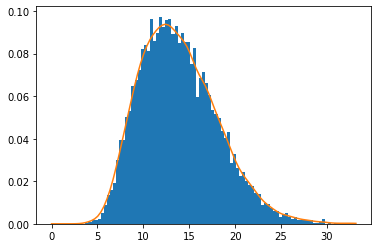

Histogram for F Test feature  1


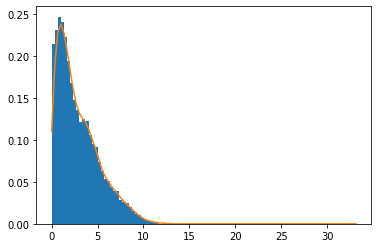

Histogram for F Test feature  2


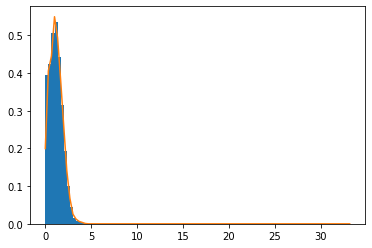

Histogram for F Test feature  3


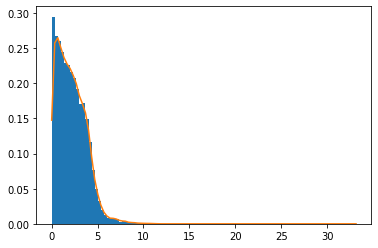

Histogram for F Test feature  4


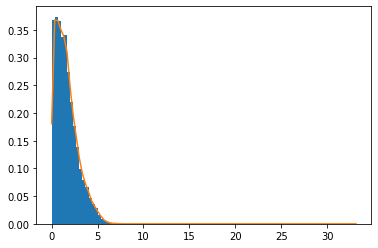

Histogram for F Test feature  5


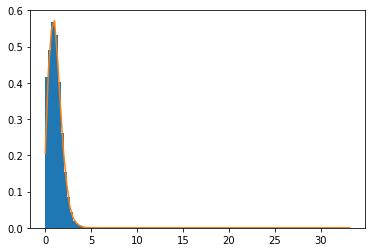

Histogram for F Test feature  6


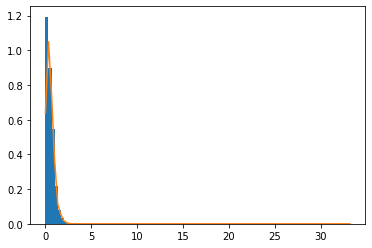

Histogram for F Test feature  7


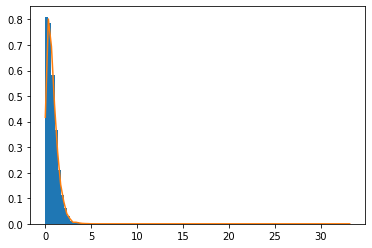

Histogram for F Test feature  8


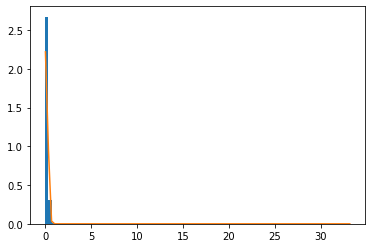

Histogram for F Test feature  9


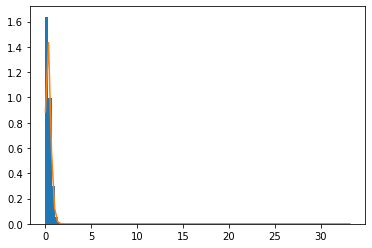

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.9451
LR Accuracy on test data - All features:  0.49905
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.934125
Logistic Regression Accuracy on test data:  0.56505
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.944325
Logistic Regression Accuracy on test data:  0.4991
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9411
Logistic Regression Accuracy on test data:  0.4646
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.942475
Logistic Regression Accuracy on test data:  0.48225
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94385
Logistic Regression Accuracy on test data:  0.48655
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.944775
Logistic Regression Accuracy on test data:  0.4874
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9379
Logistic Regression Accuracy on test data:  0.3318
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.938325
Logistic Regression Accuracy on test data:  0.44445
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.945025
Logistic Regression Accuracy on test data:  0.49865
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.943075
Logistic Regression Accuracy on test data:  0.48545




Results for lamda  9



array([-2.69512917e+00, -2.45847557e+00, -1.46489364e+00, -5.86548066e-01,
       -2.56781686e-01, -4.24931936e-02, -2.85564169e-02,  5.75116671e-15,
        5.35748319e-02,  5.59358435e-02,  7.08688644e-02,  9.43910942e-02,
        1.15530974e-01,  1.24718111e-01,  1.30053005e-01,  1.66962833e-01,
        1.93910107e-01,  2.22496597e-01,  2.65234812e-01,  3.00330427e-01,
        3.06092877e-01,  3.49914738e-01,  3.98273067e-01,  4.89764213e-01,
        5.74714955e-01,  6.64381549e-01,  6.78928934e-01,  7.12892674e-01,
        8.20686883e-01,  9.82923516e-01,  1.05145241e+00,  1.09568454e+00,
        1.26787663e+00,  1.30468375e+00,  1.35667271e+00,  1.45449438e+00,
        1.72143922e+00,  1.95645600e+00,  2.19055586e+00,  2.55741895e+00,
        3.57794554e+00,  5.09552434e+00,  5.87831896e+00,  6.69927573e+00,
        9.69822741e+00,  1.03348943e+01,  1.40334441e+01,  1.98253234e+01,
        3.64318501e+01,  2.01112592e+03])

array([[-0.08524005,  0.12775535, -0.05576832, ..., -0.20164327,
         0.214474  ,  0.11484952],
       [ 0.0244708 , -0.04388181,  0.08110138, ...,  0.06975578,
         0.1731855 ,  0.21817757],
       [ 0.04692864, -0.05236263, -0.15147108, ..., -0.43431558,
        -0.21019666,  0.07136249],
       ...,
       [-0.16034359,  0.29318751,  0.09845085, ...,  0.34655282,
         0.14490942,  0.08960931],
       [ 0.21676056, -0.17678804, -0.06776534, ...,  0.07798916,
         0.12769358,  0.16115859],
       [ 0.10434022,  0.15502228,  0.07878129, ..., -0.01972886,
        -0.04667146,  0.043195  ]])

Printing least k eigenvalues before removing the zero eigenvalue
[-2.69512917 -2.45847557 -1.46489364 -0.58654807 -0.25678169 -0.04249319
 -0.02855642  0.          0.05357483  0.05593584]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-2.69512917 -2.45847557 -1.46489364 -0.58654807 -0.25678169 -0.04249319
 -0.02855642  0.05357483  0.05593584]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 8 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.438054,2.126476,0.899536,2.651023,0.258305,1.081441,0.390062,0.496529,0.679014,0.352080
1,7.417415,1.315992,1.467943,2.725955,0.385795,1.018177,0.339118,0.913321,0.382128,0.169199
2,12.806093,2.897195,1.175576,1.019783,0.833531,0.924160,0.392069,0.642657,0.437547,0.030165
3,12.231457,6.202900,0.994407,2.337690,3.268042,1.329667,0.727708,0.615857,0.319231,0.316689
4,18.430882,4.757543,3.149346,0.282941,2.431074,1.883584,1.102290,0.148795,0.189464,0.235088


Histogram for F Test feature  0


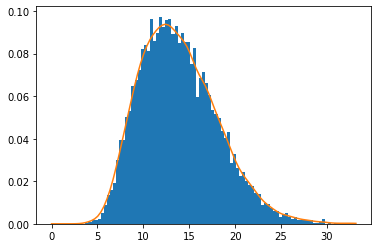

Histogram for F Test feature  1


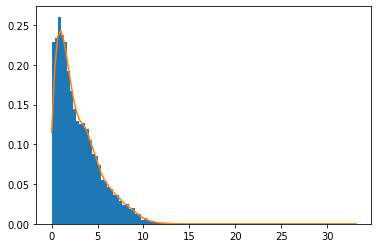

Histogram for F Test feature  2


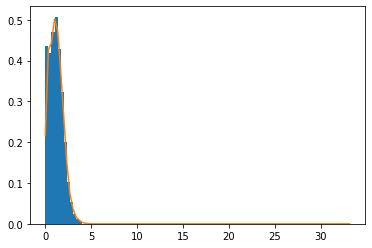

Histogram for F Test feature  3


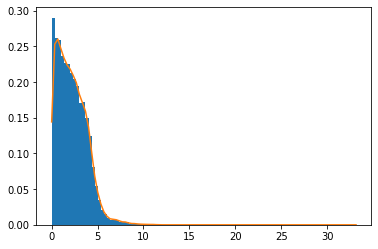

Histogram for F Test feature  4


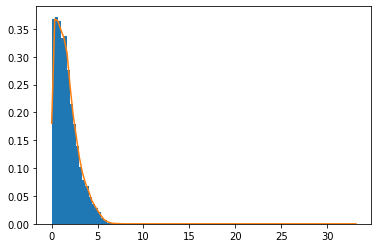

Histogram for F Test feature  5


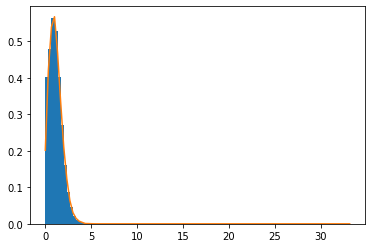

Histogram for F Test feature  6


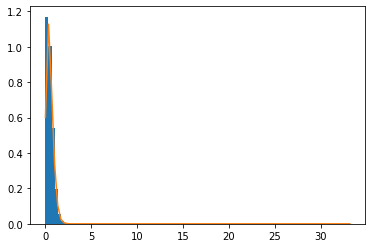

Histogram for F Test feature  7


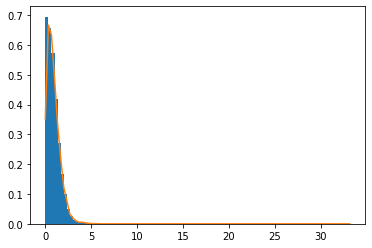

Histogram for F Test feature  8


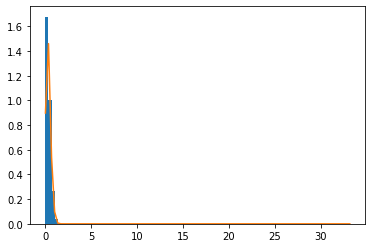

Histogram for F Test feature  9


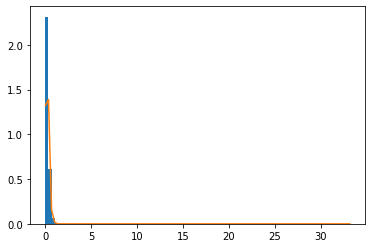

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.946725
LR Accuracy on test data - All features:  0.51695
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.93515
Logistic Regression Accuracy on test data:  0.57765
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94485
Logistic Regression Accuracy on test data:  0.51165
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.942225
Logistic Regression Accuracy on test data:  0.47885
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9445
Logistic Regression Accuracy on test data:  0.5006
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.945375
Logistic Regression Accuracy on test data:  0.50385
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9467
Logistic Regression Accuracy on test data:  0.50205
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.933275
Logistic Regression Accuracy on test data:  0.2459
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.942975
Logistic Regression Accuracy on test data:  0.4948
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94545
Logistic Regression Accuracy on test data:  0.50605
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9466
Logistic Regression Accuracy on test data:  0.51505




Results for lamda  8



array([-2.80609056e+00, -2.65674049e+00, -1.53921931e+00, -6.47650174e-01,
       -3.01952496e-01, -8.26278695e-02, -7.04676634e-02, -7.32552656e-16,
        3.48477706e-02,  4.59398938e-02,  5.69185054e-02,  7.76530673e-02,
        9.64915965e-02,  1.04457053e-01,  1.11865444e-01,  1.39274353e-01,
        1.63846513e-01,  1.92586052e-01,  2.29749093e-01,  2.58213991e-01,
        2.63977248e-01,  3.03288994e-01,  3.41583098e-01,  4.27849556e-01,
        4.91103272e-01,  5.69510429e-01,  5.85702493e-01,  6.16395149e-01,
        7.13072512e-01,  8.56919763e-01,  9.09334671e-01,  9.49623681e-01,
        1.10406398e+00,  1.14545080e+00,  1.17798226e+00,  1.27849597e+00,
        1.48847451e+00,  1.70371520e+00,  1.91592978e+00,  2.21161351e+00,
        3.09276913e+00,  4.49130654e+00,  5.06727178e+00,  5.89633206e+00,
        8.48234407e+00,  9.05425932e+00,  1.23922590e+01,  1.75597523e+01,
        3.22692299e+01,  1.77650808e+03])

array([[-0.1047146 ,  0.12137395, -0.05315241, ..., -0.20210465,
         0.21370274,  0.11463458],
       [ 0.03017067, -0.04702466,  0.08112997, ...,  0.07027686,
         0.17337739,  0.21833312],
       [ 0.04692747, -0.04065602, -0.15183624, ..., -0.4336834 ,
        -0.21124238,  0.07140519],
       ...,
       [-0.20689002,  0.2657967 ,  0.11088081, ...,  0.3453563 ,
         0.1450294 ,  0.08917853],
       [ 0.23320129, -0.13482141, -0.07304676, ...,  0.07815299,
         0.12852496,  0.16132699],
       [ 0.08042607,  0.17121602,  0.08323907, ..., -0.01974378,
        -0.04680723,  0.04296593]])

Printing least k eigenvalues before removing the zero eigenvalue
[-2.80609056 -2.65674049 -1.53921931 -0.64765017 -0.3019525  -0.08262787
 -0.07046766  0.          0.03484777  0.04593989]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-2.80609056 -2.65674049 -1.53921931 -0.64765017 -0.3019525  -0.08262787
 -0.07046766  0.03484777  0.04593989]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 8 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.438054,1.966725,1.124570,2.682642,0.275308,1.121400,0.300465,0.580698,0.837289,0.254899
1,7.417415,1.107870,1.603502,2.762172,0.382107,1.035070,0.030068,1.024245,0.385406,0.084955
2,12.806093,2.695757,1.565029,1.047687,0.844758,0.971516,0.661891,0.567473,0.379961,0.188046
3,12.231457,6.289386,0.086908,2.405255,3.306429,1.302869,0.900913,0.368279,0.117832,0.405214
4,18.430882,4.208852,3.829541,0.354195,2.430252,1.964422,1.052202,0.450257,0.093526,0.305484


Histogram for F Test feature  0


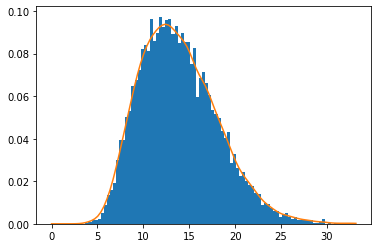

Histogram for F Test feature  1


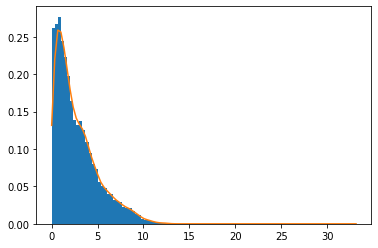

Histogram for F Test feature  2


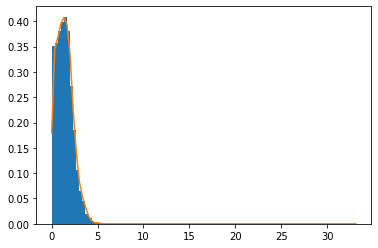

Histogram for F Test feature  3


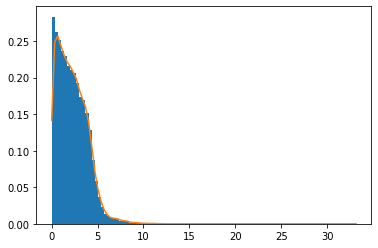

Histogram for F Test feature  4


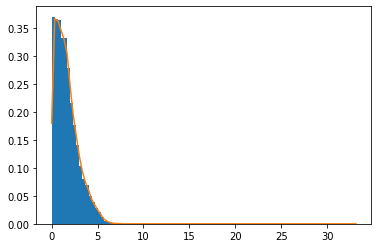

Histogram for F Test feature  5


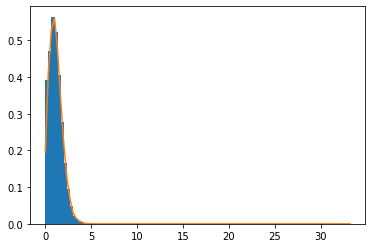

Histogram for F Test feature  6


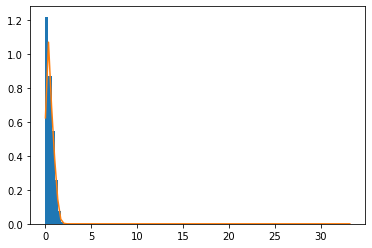

Histogram for F Test feature  7


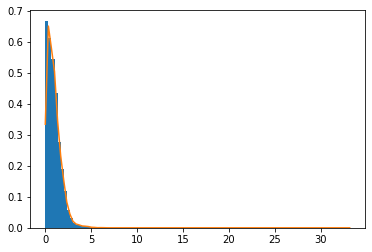

Histogram for F Test feature  8


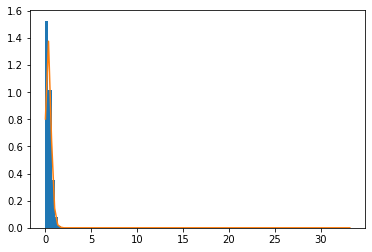

Histogram for F Test feature  9


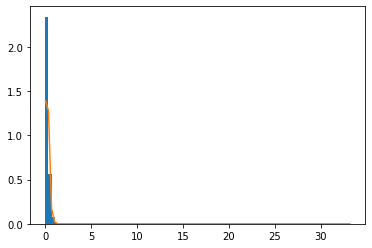

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.948525
LR Accuracy on test data - All features:  0.5359
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9365
Logistic Regression Accuracy on test data:  0.59105
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.945275
Logistic Regression Accuracy on test data:  0.5234
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.943775
Logistic Regression Accuracy on test data:  0.4945
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.946475
Logistic Regression Accuracy on test data:  0.5206
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9478
Logistic Regression Accuracy on test data:  0.525
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.948575
Logistic Regression Accuracy on test data:  0.5155
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.930925
Logistic Regression Accuracy on test data:  0.19845
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9489
Logistic Regression Accuracy on test data:  0.53255
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94665
Logistic Regression Accuracy on test data:  0.52335
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.948525
Logistic Regression Accuracy on test data:  0.53445




Results for lamda  7



array([-2.95202067e+00, -2.85017826e+00, -1.61509837e+00, -7.12107727e-01,
       -3.52352283e-01, -1.33832815e-01, -1.14484570e-01,  1.15892585e-14,
        1.30573195e-02,  3.52099380e-02,  4.51609840e-02,  6.09544125e-02,
        7.81912575e-02,  8.38046958e-02,  9.34731068e-02,  1.12918164e-01,
        1.33396558e-01,  1.62920037e-01,  1.94396419e-01,  2.15749831e-01,
        2.23049248e-01,  2.55685494e-01,  2.85620455e-01,  3.64931488e-01,
        4.05296380e-01,  4.71254322e-01,  5.00028137e-01,  5.21517050e-01,
        6.04820161e-01,  7.32556208e-01,  7.63563054e-01,  8.10324180e-01,
        9.40753573e-01,  9.83486793e-01,  1.00183115e+00,  1.10351880e+00,
        1.25814334e+00,  1.45394209e+00,  1.64324894e+00,  1.86978219e+00,
        2.61248889e+00,  3.88688711e+00,  4.25643001e+00,  5.09717992e+00,
        7.26226907e+00,  7.78918693e+00,  1.07539965e+01,  1.52951976e+01,
        2.81072515e+01,  1.54189902e+03])

array([[-0.15293377,  0.06543253, -0.05056176, ..., -0.20267539,
         0.2127023 ,  0.11435414],
       [ 0.05089975, -0.03498754,  0.0814365 , ...,  0.07089971,
         0.17362644,  0.21853524],
       [ 0.05178123, -0.01466431, -0.15181903, ..., -0.43279414,
        -0.21258838,  0.07146068],
       ...,
       [-0.30993706,  0.13905881,  0.12294162, ...,  0.34386131,
         0.14521094,  0.08861688],
       [ 0.25857025, -0.00954031, -0.07710856, ...,  0.07830877,
         0.12958944,  0.161546  ],
       [-0.00843812,  0.1920703 ,  0.08717687, ..., -0.01971122,
        -0.04697812,  0.04266728]])

Printing least k eigenvalues before removing the zero eigenvalue
[-2.95202067 -2.85017826 -1.61509837 -0.71210773 -0.35235228 -0.13383281
 -0.11448457  0.          0.01305732  0.03520994]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-2.95202067 -2.85017826 -1.61509837 -0.71210773 -0.35235228 -0.13383281
 -0.11448457  0.01305732  0.03520994]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 8 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.438054,1.258365,1.833307,2.711347,0.289838,1.156961,0.245192,0.659759,0.925629,0.299808
1,7.417415,0.286251,1.908514,2.795185,0.385540,1.050439,0.350298,0.988312,0.377124,0.081641
2,12.806093,1.694504,2.605192,1.074812,0.857749,1.012238,0.888677,0.397705,0.340458,0.269868
3,12.231457,5.481061,3.100921,2.463886,3.347202,1.250401,0.992320,0.117837,0.006322,0.416456
4,18.430882,1.961289,5.319393,0.425490,2.436107,2.030816,0.986770,0.709432,0.059689,0.321209


Histogram for F Test feature  0


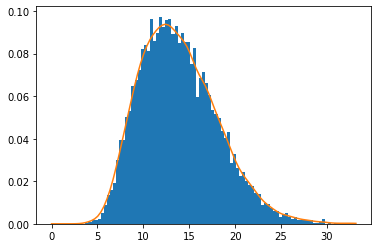

Histogram for F Test feature  1


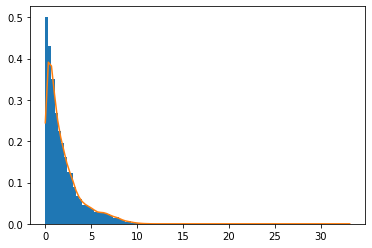

Histogram for F Test feature  2


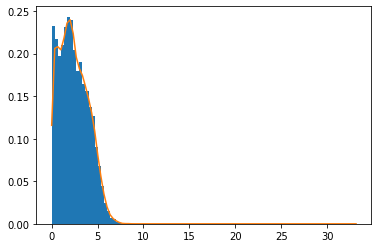

Histogram for F Test feature  3


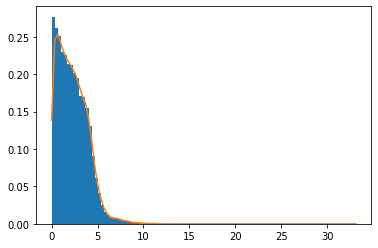

Histogram for F Test feature  4


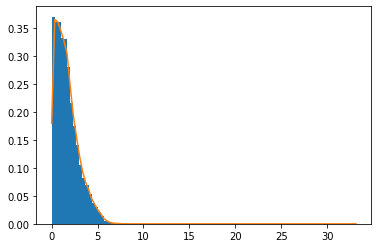

Histogram for F Test feature  5


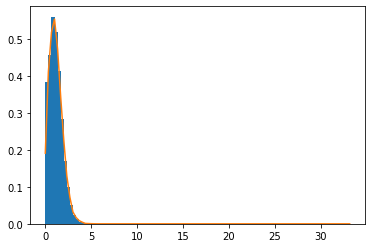

Histogram for F Test feature  6


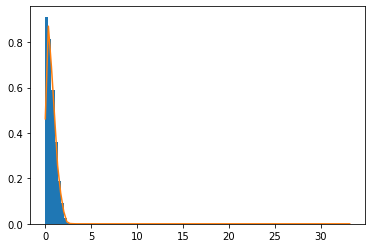

Histogram for F Test feature  7


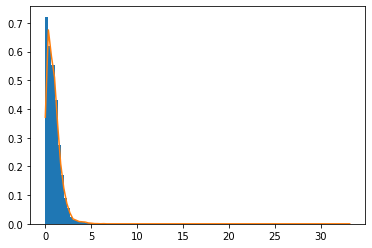

Histogram for F Test feature  8


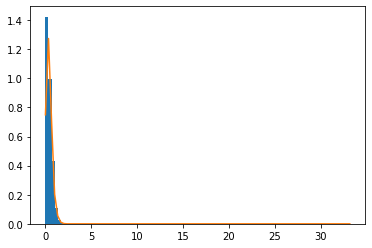

Histogram for F Test feature  9


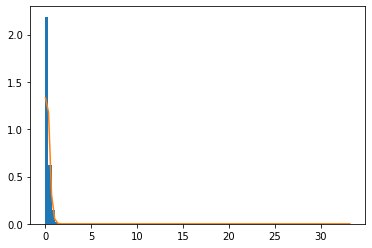

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.950325
LR Accuracy on test data - All features:  0.55685
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9383
Logistic Regression Accuracy on test data:  0.61115
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.94515
Logistic Regression Accuracy on test data:  0.53045
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.948425
Logistic Regression Accuracy on test data:  0.53375
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.948725
Logistic Regression Accuracy on test data:  0.5455
Accuracy for without feature  4
Logistic Regression Accuracy within training data:  0.949475
Logistic Regression Accuracy on test data:  0.5487
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.949925
Logistic Regression Accuracy on test data:  0.53415
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.928225
Logistic Regression Accuracy on test data:  0.2437
Accuracy for without feature  7
Logistic Regression Accuracy within training data:  0.95105
Logistic Regression Accuracy on test data:  0.52625
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.948475
Logistic Regression Accuracy on test data:  0.54615
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.950375
Logistic Regression Accuracy on test data:  0.55675




Results for lamda  6



array([-3.18509919e+00, -2.99505777e+00, -1.69319565e+00, -7.80739902e-01,
       -4.10205280e-01, -1.96820884e-01, -1.63725808e-01, -1.33766986e-02,
        2.27165601e-14,  2.24928741e-02,  3.37253651e-02,  4.44737224e-02,
        5.83963011e-02,  6.38762743e-02,  7.43533319e-02,  8.82410351e-02,
        1.02482608e-01,  1.33296455e-01,  1.59134082e-01,  1.72946500e-01,
        1.82824744e-01,  2.05904894e-01,  2.30769825e-01,  2.97456486e-01,
        3.20210849e-01,  3.78851267e-01,  4.15253402e-01,  4.29269780e-01,
        4.95177061e-01,  6.08962251e-01,  6.19587336e-01,  6.74842728e-01,
        7.78114283e-01,  8.08500897e-01,  8.36809021e-01,  9.29699241e-01,
        1.03204045e+00,  1.20813238e+00,  1.37292210e+00,  1.53397673e+00,
        2.13908700e+00,  3.28008829e+00,  3.45136154e+00,  4.30084295e+00,
        6.03766099e+00,  6.54521573e+00,  9.11955503e+00,  1.30320756e+01,
        2.39462263e+01,  1.30730344e+03])

array([[ 0.17157939, -0.00344278,  0.04805022, ..., -0.2033988 ,
         0.21135287,  0.11397287],
       [-0.06607032, -0.01561247, -0.08212252, ...,  0.07165129,
         0.17396273,  0.21880852],
       [-0.04510599,  0.00488117,  0.1515165 , ..., -0.43149026,
        -0.21438598,  0.07153572],
       ...,
       [ 0.34285175, -0.01069266, -0.13488529, ...,  0.34193596,
         0.14549948,  0.08785409],
       [-0.22653334,  0.10032458,  0.08010611, ...,  0.07842573,
         0.13100144,  0.16184246],
       [ 0.09346486,  0.17267372, -0.09050299, ..., -0.01958648,
        -0.0471997 ,  0.04226168]])

Printing least k eigenvalues before removing the zero eigenvalue
[-3.18509919 -2.99505777 -1.69319565 -0.7807399  -0.41020528 -0.19682088
 -0.16372581 -0.0133767   0.          0.02249287]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-3.18509919 -2.99505777 -1.69319565 -0.7807399  -0.41020528 -0.19682088
 -0.16372581 -0.0133767   0.02249287]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.438054,0.395205,2.146070,2.738282,0.301325,1.180144,0.370353,0.705290,0.971512,0.382716
1,7.417415,0.518017,1.840526,2.826686,0.397644,1.062958,0.409062,0.978631,0.379146,0.090274
2,12.806093,0.438650,3.067284,1.101959,0.872770,1.038648,1.009387,0.387539,0.330827,0.352389
3,12.231457,3.493441,5.247589,2.514994,3.389151,1.155827,1.049378,0.103154,0.111969,0.415528
4,18.430882,0.511127,5.618681,0.498179,2.449693,2.067641,1.118577,0.748994,0.073195,0.301004


Histogram for F Test feature  0


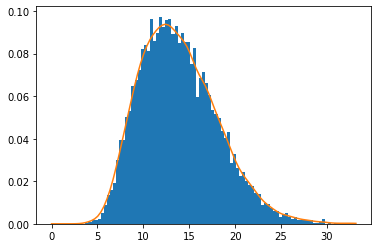

Histogram for F Test feature  1


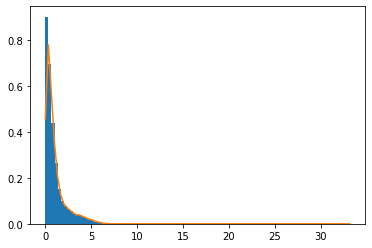

Histogram for F Test feature  2


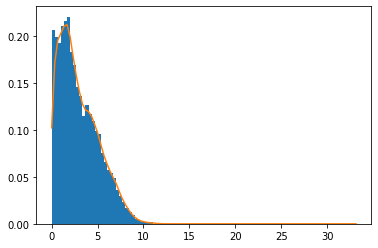

Histogram for F Test feature  3


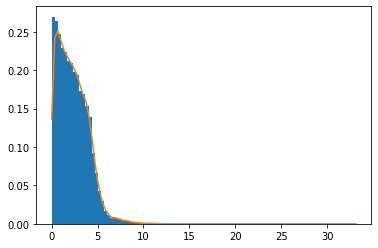

Histogram for F Test feature  4


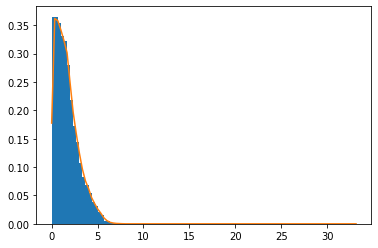

Histogram for F Test feature  5


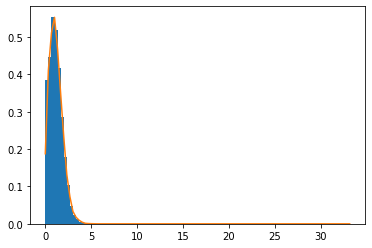

Histogram for F Test feature  6


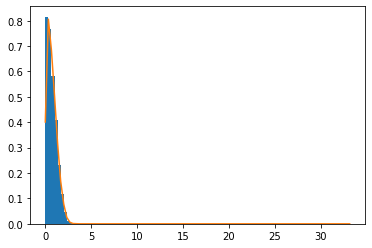

Histogram for F Test feature  7


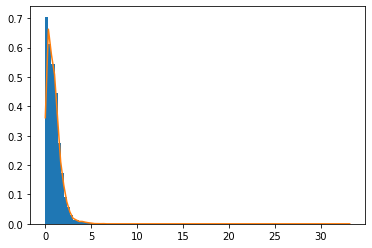

Histogram for F Test feature  8


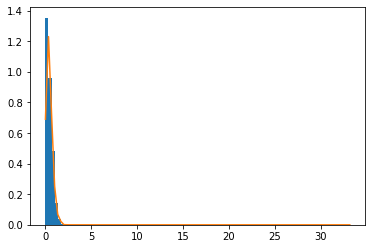

Histogram for F Test feature  9


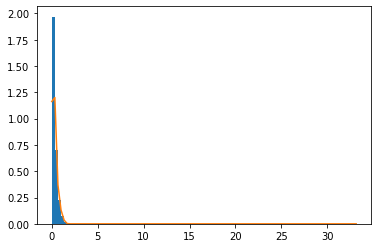

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.952225
LR Accuracy on test data - All features:  0.5822
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9406
Logistic Regression Accuracy on test data:  0.6388
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.94705
Logistic Regression Accuracy on test data:  0.5472
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.95215
Logistic Regression Accuracy on test data:  0.58215
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.951525
Logistic Regression Accuracy on test data:  0.5747
Accuracy for without feature  4
Logistic Regression Accuracy within training data:  0.9514
Logistic Regression Accuracy on test data:  0.5743
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.950375
Logistic Regression Accuracy on test data:  0.55195
Accuracy for without feature  6
Logistic Regression Accuracy within training data:  0.928925
Logistic Regression Accuracy on test data:  0.2884
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.95245
Logistic Regression Accuracy on test data:  0.5432
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9509
Logistic Regression Accuracy on test data:  0.57315
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9525
Logistic Regression Accuracy on test data:  0.58175




Results for lamda  5



array([-3.48578706e+00, -3.12518502e+00, -1.77447478e+00, -8.54763642e-01,
       -4.79554568e-01, -2.76037006e-01, -2.22548796e-01, -4.76595865e-02,
        1.90072360e-14,  3.66838841e-03,  1.78857594e-02,  2.82673036e-02,
        3.59101136e-02,  4.66643875e-02,  5.22637948e-02,  6.37959025e-02,
        7.44284590e-02,  1.03036399e-01,  1.22573768e-01,  1.30571160e-01,
        1.42418598e-01,  1.52029317e-01,  1.77304424e-01,  2.20056585e-01,
        2.48443478e-01,  2.92939450e-01,  3.30799160e-01,  3.40603297e-01,
        3.82596608e-01,  4.74767243e-01,  4.93140075e-01,  5.40841535e-01,
        6.11716252e-01,  6.28073866e-01,  6.78030737e-01,  7.57172521e-01,
        8.14060029e-01,  9.67746917e-01,  1.10558014e+00,  1.20768988e+00,
        1.67545026e+00,  2.62370640e+00,  2.70604175e+00,  3.50507225e+00,
        4.81271075e+00,  5.32749280e+00,  7.49024906e+00,  1.07710662e+01,
        1.97867075e+01,  1.07273012e+03])

array([[-0.17412279,  0.02546749, -0.04566682, ..., -0.20434323,
         0.20943374,  0.11342454],
       [ 0.0731744 ,  0.01191504,  0.0833091 , ...,  0.07256023,
         0.17444191,  0.21919854],
       [ 0.03609345, -0.00583698, -0.15104951, ..., -0.42947175,
        -0.21690892,  0.07164284],
       ...,
       [-0.34138299,  0.0622013 ,  0.14706823, ...,  0.33935316,
         0.14598963,  0.08675861],
       [ 0.19901074, -0.12725913, -0.08217755, ...,  0.07842718,
         0.13296527,  0.16226625],
       [-0.12188665, -0.16066598,  0.09301635, ..., -0.01927577,
        -0.04749821,  0.04167916]])

Printing least k eigenvalues before removing the zero eigenvalue
[-3.48578706 -3.12518502 -1.77447478 -0.85476364 -0.47955457 -0.27603701
 -0.2225488  -0.04765959  0.          0.00366839]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-3.48578706 -3.12518502 -1.77447478 -0.85476364 -0.47955457 -0.27603701
 -0.2225488  -0.04765959  0.00366839]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 9]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.438054,0.132149,2.136316,2.764438,0.309021,1.171451,0.625791,0.706944,0.964729,0.544949
1,7.417415,0.728634,1.747452,2.858549,0.421227,1.069792,0.353773,1.006693,0.381780,0.098115
2,12.806093,0.029933,3.088976,1.129953,0.890143,1.032148,1.109775,0.497050,0.355057,0.431081
3,12.231457,2.569807,5.762299,2.560475,3.429083,0.984575,1.140951,0.230722,0.214707,0.374866
4,18.430882,1.279931,5.458059,0.573989,2.471777,2.037016,1.431319,0.658476,0.148781,0.269102


Histogram for F Test feature  0


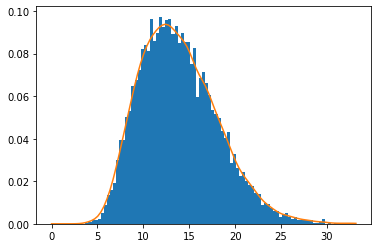

Histogram for F Test feature  1


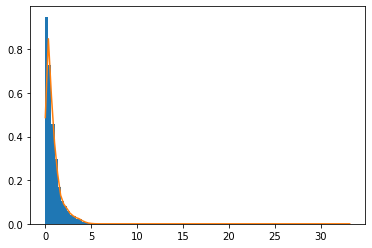

Histogram for F Test feature  2


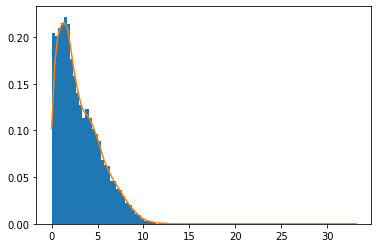

Histogram for F Test feature  3


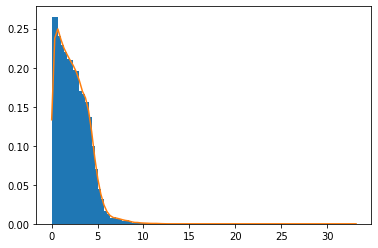

Histogram for F Test feature  4


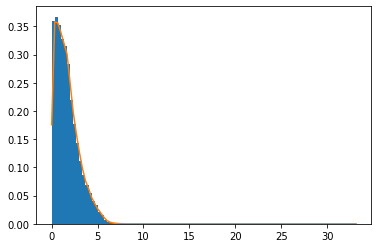

Histogram for F Test feature  5


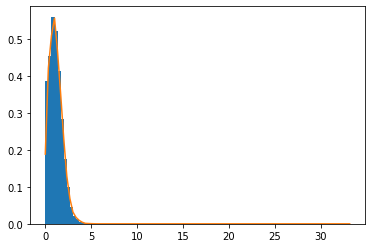

Histogram for F Test feature  6


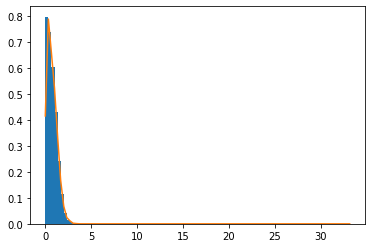

Histogram for F Test feature  7


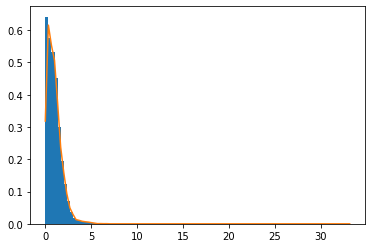

Histogram for F Test feature  8


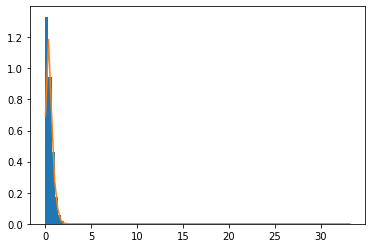

Histogram for F Test feature  9


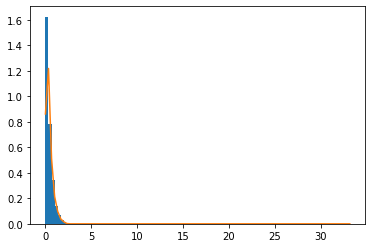

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.9546
LR Accuracy on test data - All features:  0.61135
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9434
Logistic Regression Accuracy on test data:  0.67305
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.94965
Logistic Regression Accuracy on test data:  0.5789
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.95395
Logistic Regression Accuracy on test data:  0.61285
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.95405
Logistic Regression Accuracy on test data:  0.6056
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.95375
Logistic Regression Accuracy on test data:  0.602
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.95205
Logistic Regression Accuracy on test data:  0.57105
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.930025
Logistic Regression Accuracy on test data:  0.3171
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.954225
Logistic Regression Accuracy on test data:  0.5825
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.953725
Logistic Regression Accuracy on test data:  0.60715
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9547
Logistic Regression Accuracy on test data:  0.60975




Results for lamda  4



array([-3.86080248e+00, -3.26057988e+00, -1.86051552e+00, -9.36156541e-01,
       -5.69412103e-01, -3.84103846e-01, -2.94823044e-01, -1.01889879e-01,
       -3.31508621e-02, -1.37626212e-02,  3.73482680e-15,  4.42568535e-03,
        2.20312720e-02,  2.44264836e-02,  3.08888399e-02,  4.33079590e-02,
        5.30677395e-02,  6.94188082e-02,  7.57940248e-02,  9.30609764e-02,
        9.67145447e-02,  1.02643835e-01,  1.27576100e-01,  1.52143436e-01,
        1.82704808e-01,  2.11239221e-01,  2.47361374e-01,  2.54207008e-01,
        2.66627750e-01,  3.42225504e-01,  3.75863531e-01,  4.05705245e-01,
        4.28206335e-01,  4.66700081e-01,  5.20008051e-01,  5.85597522e-01,
        6.11009240e-01,  7.34693150e-01,  8.42261021e-01,  8.96255718e-01,
        1.22560089e+00,  1.86225932e+00,  2.09094081e+00,  2.70381342e+00,
        3.60296631e+00,  4.13985974e+00,  5.86810424e+00,  8.51335893e+00,
        1.56297836e+01,  8.38197659e+02])

array([[-0.17583225, -0.03462123,  0.0434782 , ..., -0.20562029,
         0.20648911,  0.11256865],
       [ 0.07905854, -0.01362892, -0.08515605, ...,  0.07363207,
         0.17517961,  0.21980027],
       [ 0.02708233,  0.00232723,  0.15057541, ..., -0.4261047 ,
        -0.22070891,  0.07180816],
       ...,
       [-0.34114002, -0.08627701, -0.16003855, ...,  0.33568012,
         0.14690427,  0.08505234],
       [ 0.1791299 ,  0.13420428,  0.08342685, ...,  0.07810557,
         0.13588571,  0.16292169],
       [-0.13823663,  0.1560017 , -0.09430168, ..., -0.01856222,
        -0.04792144,  0.04077186]])

Printing least k eigenvalues before removing the zero eigenvalue
[-3.86080248 -3.26057988 -1.86051552 -0.93615654 -0.5694121  -0.38410385
 -0.29482304 -0.10188988 -0.03315086 -0.01376262]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-3.86080248 -3.26057988 -1.86051552 -0.93615654 -0.5694121  -0.38410385
 -0.29482304 -0.10188988 -0.03315086]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.438054,0.036791,2.097595,2.790807,0.311811,1.075914,0.974442,0.610235,0.804498,0.728857
1,7.417415,0.787079,1.697387,2.893204,0.462528,1.062517,0.285012,1.030418,0.345069,0.146940
2,12.806093,0.132676,3.076831,1.159765,0.910049,0.939142,1.223967,0.692959,0.386627,0.337792
3,12.231457,2.039713,5.974010,2.603048,3.458214,0.647836,1.276264,0.465515,0.348827,0.130147
4,18.430882,1.578984,5.330908,0.655315,2.501466,1.825772,1.921167,0.423879,0.266416,0.222957


Histogram for F Test feature  0


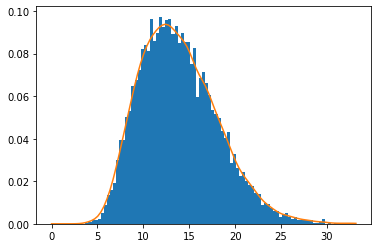

Histogram for F Test feature  1


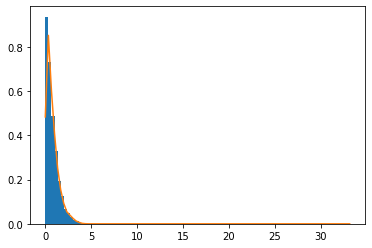

Histogram for F Test feature  2


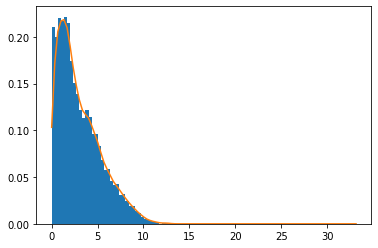

Histogram for F Test feature  3


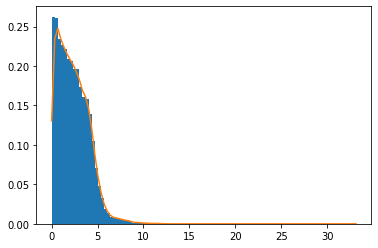

Histogram for F Test feature  4


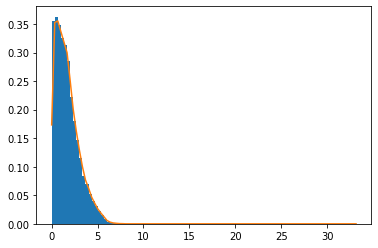

Histogram for F Test feature  5


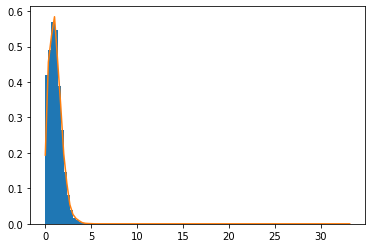

Histogram for F Test feature  6


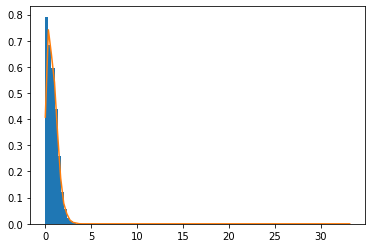

Histogram for F Test feature  7


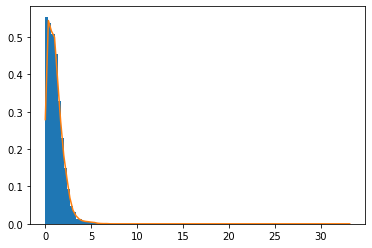

Histogram for F Test feature  8


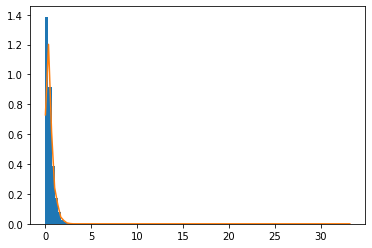

Histogram for F Test feature  9


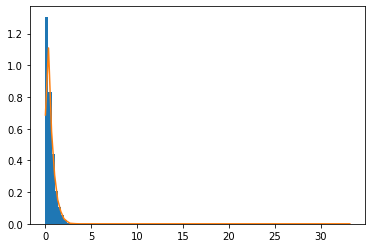

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.956875
LR Accuracy on test data - All features:  0.63525
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.947075
Logistic Regression Accuracy on test data:  0.70195
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.953375
Logistic Regression Accuracy on test data:  0.61445
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.95655
Logistic Regression Accuracy on test data:  0.63685
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.956575
Logistic Regression Accuracy on test data:  0.6349
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.955725
Logistic Regression Accuracy on test data:  0.6227
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.952675
Logistic Regression Accuracy on test data:  0.57385
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.934475
Logistic Regression Accuracy on test data:  0.38005
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.957225
Logistic Regression Accuracy on test data:  0.6224
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.956525
Logistic Regression Accuracy on test data:  0.6355
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9569
Logistic Regression Accuracy on test data:  0.6352




Results for lamda  3



array([-4.36393563e+00, -3.40687732e+00, -1.95436479e+00, -1.02894900e+00,
       -7.06615241e-01, -5.39437158e-01, -3.86910104e-01, -2.12274151e-01,
       -9.78096557e-02, -6.79781160e-02, -3.84193042e-02,  2.08454546e-14,
        4.45629671e-04,  2.64073910e-03,  1.04864847e-02,  1.84705440e-02,
        2.92625681e-02,  3.21271864e-02,  3.49574577e-02,  5.52014142e-02,
        6.01610583e-02,  6.51778901e-02,  8.42571795e-02,  9.21431932e-02,
        1.16352517e-01,  1.31228040e-01,  1.52538676e-01,  1.69845237e-01,
        1.74785619e-01,  2.20940798e-01,  2.49761427e-01,  2.61741370e-01,
        2.80770729e-01,  3.16065370e-01,  3.62658054e-01,  4.12277152e-01,
        4.29772715e-01,  5.11015035e-01,  5.84998587e-01,  6.05597353e-01,
        7.96088340e-01,  1.14843312e+00,  1.48959701e+00,  1.87935839e+00,
        2.45249453e+00,  2.98595954e+00,  4.25651234e+00,  6.26123015e+00,
        1.14779450e+01,  6.03753217e+02])

array([[ 0.17651117,  0.0401352 ,  0.0416214 , ..., -0.20740856,
         0.20140383,  0.11104631],
       [-0.08358394,  0.01786423, -0.08789865, ...,  0.07471459,
         0.17646136,  0.22084956],
       [-0.01709163,  0.00211274,  0.15026262, ..., -0.41983129,
        -0.22708946,  0.07209662],
       ...,
       [ 0.34300679,  0.10162245, -0.17476382, ...,  0.32995326,
         0.14887253,  0.0820283 ],
       [-0.16110668, -0.13462498,  0.08386882, ...,  0.07680764,
         0.14069603,  0.16406954],
       [ 0.15211383, -0.15439325, -0.09347258, ..., -0.01686421,
        -0.04856472,  0.03916383]])

Printing least k eigenvalues before removing the zero eigenvalue
[-4.36393563 -3.40687732 -1.95436479 -1.028949   -0.70661524 -0.53943716
 -0.3869101  -0.21227415 -0.09780966 -0.06797812]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-4.36393563 -3.40687732 -1.95436479 -1.028949   -0.70661524 -0.53943716
 -0.3869101  -0.21227415 -0.09780966]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.438054,0.011890,2.054597,2.818623,0.306971,0.734645,1.324587,0.354363,0.281075,0.875953
1,7.417415,0.791477,1.663365,2.934376,0.541394,1.002504,0.340515,1.020534,0.170333,0.108106
2,12.806093,0.217808,3.062685,1.192855,0.930105,0.595409,1.380037,0.952133,0.226431,0.015041
3,12.231457,1.625729,6.100059,2.646806,3.443207,0.107248,1.385997,0.792306,0.543726,0.223515
4,18.430882,1.718183,5.224359,0.746063,2.526247,1.065477,2.548739,0.002327,0.116835,0.271743


Histogram for F Test feature  0


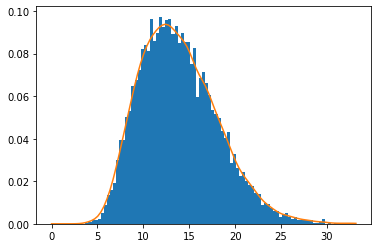

Histogram for F Test feature  1


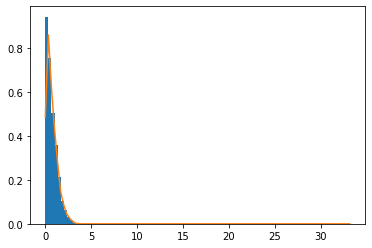

Histogram for F Test feature  2


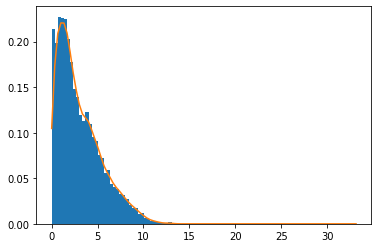

Histogram for F Test feature  3


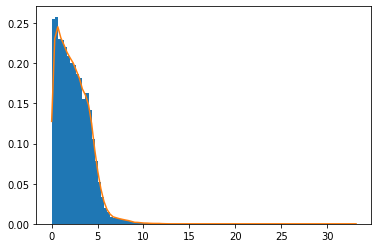

Histogram for F Test feature  4


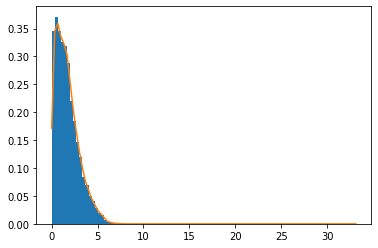

Histogram for F Test feature  5


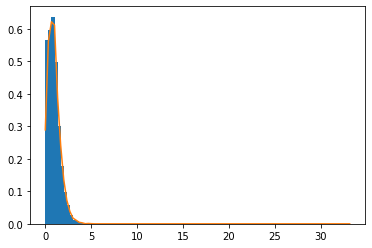

Histogram for F Test feature  6


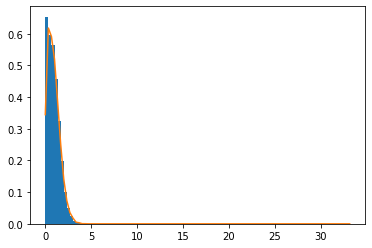

Histogram for F Test feature  7


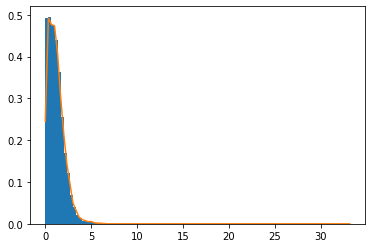

Histogram for F Test feature  8


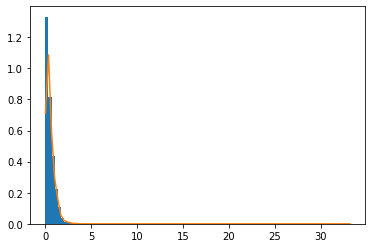

Histogram for F Test feature  9


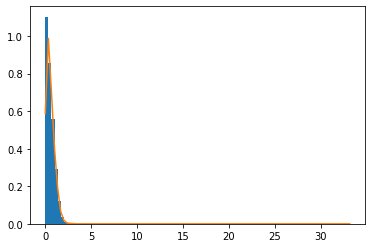

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.9592
LR Accuracy on test data - All features:  0.6629
Accuracy for without feature  0
Logistic Regression Accuracy within training data:  0.95165
Logistic Regression Accuracy on test data:  0.7258
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.95645
Logistic Regression Accuracy on test data:  0.64795
Accuracy for without feature  2
Logistic Regression Accuracy within training data:  0.959
Logistic Regression Accuracy on test data:  0.6666
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.959225
Logistic Regression Accuracy on test data:  0.6625
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.95675
Logistic Regression Accuracy on test data:  0.6381
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.949575
Logistic Regression Accuracy on test data:  0.5289
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.946725
Logistic Regression Accuracy on test data:  0.53565
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9592
Logistic Regression Accuracy on test data:  0.65685
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.959
Logistic Regression Accuracy on test data:  0.66185
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9594
Logistic Regression Accuracy on test data:  0.6626




Results for lamda  2



array([-5.17242862e+00, -3.56915124e+00, -2.06344785e+00, -1.15077606e+00,
       -9.60709316e-01, -7.59458967e-01, -5.22331504e-01, -4.15322409e-01,
       -2.61930981e-01, -1.49976604e-01, -1.13235991e-01, -6.79161858e-02,
       -3.88928688e-02, -4.92258952e-03,  1.55579646e-14,  7.18218734e-04,
        1.10765031e-02,  1.32929844e-02,  1.59150916e-02,  2.07076228e-02,
        2.34248730e-02,  3.35305366e-02,  3.65453201e-02,  4.41297673e-02,
        5.82044057e-02,  6.77355494e-02,  7.60149811e-02,  8.41360712e-02,
        1.02028417e-01,  1.13147551e-01,  1.24118590e-01,  1.39054165e-01,
        1.62777102e-01,  1.76092661e-01,  2.10363940e-01,  2.40903076e-01,
        2.65422981e-01,  2.98232368e-01,  3.37173796e-01,  3.40095035e-01,
        4.13412702e-01,  5.65304794e-01,  8.87028686e-01,  1.02441067e+00,
        1.45227128e+00,  1.87191794e+00,  2.66219085e+00,  4.01954031e+00,
        7.33850549e+00,  3.69561653e+02])

array([[ 0.17578677,  0.04484108, -0.04047882, ...,  0.20986476,
         0.19056058,  0.10758922],
       [-0.08471794,  0.02437255,  0.09196073, ..., -0.07460963,
         0.17922198,  0.22313511],
       [-0.00617503,  0.00570299, -0.14983466, ...,  0.40573559,
        -0.24004714,  0.07272583],
       ...,
       [ 0.3461235 ,  0.11316099,  0.19332084, ..., -0.31935907,
         0.15427089,  0.07521138],
       [-0.14137888, -0.13147555, -0.08316979, ..., -0.07182588,
         0.15015158,  0.16659288],
       [ 0.16522432, -0.15452313,  0.08838613, ...,  0.01218496,
        -0.04963275,  0.03553886]])

Printing least k eigenvalues before removing the zero eigenvalue
[-5.17242862 -3.56915124 -2.06344785 -1.15077606 -0.96070932 -0.75945897
 -0.5223315  -0.41532241 -0.26193098 -0.1499766 ]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-5.17242862 -3.56915124 -2.06344785 -1.15077606 -0.96070932 -0.75945897
 -0.5223315  -0.41532241 -0.26193098]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.438054,0.046560,2.010385,2.849144,0.269269,0.104358,1.278199,0.178697,0.349787,1.161832
1,7.417415,0.761646,1.633589,2.988083,0.778513,0.755511,0.427289,0.908822,0.313034,0.557588
2,12.806093,0.272150,3.050061,1.231870,0.893658,0.163913,1.308087,1.269502,0.292069,0.008081
3,12.231457,1.243516,6.185254,2.696849,3.066277,1.736610,0.969564,1.114098,0.925233,0.325116
4,18.430882,1.779646,5.122035,0.853860,2.354337,0.745821,2.638647,0.782948,0.541733,1.022446


Histogram for F Test feature  0


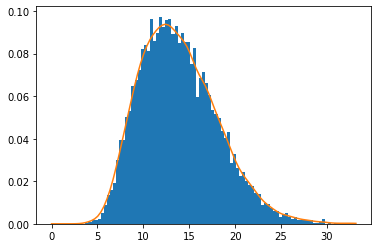

Histogram for F Test feature  1


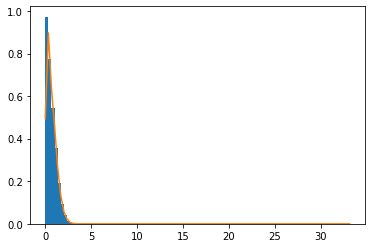

Histogram for F Test feature  2


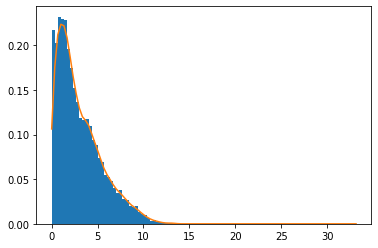

Histogram for F Test feature  3


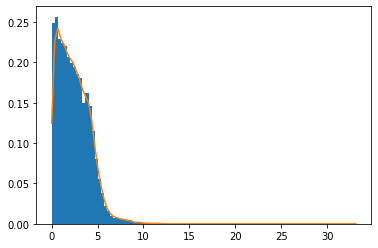

Histogram for F Test feature  4


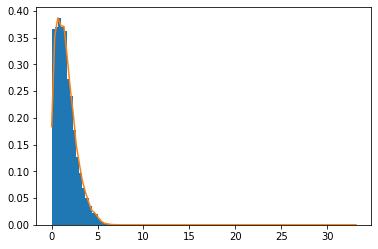

Histogram for F Test feature  5


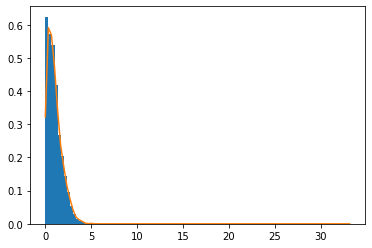

Histogram for F Test feature  6


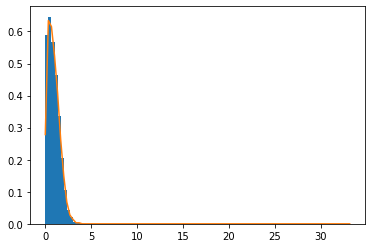

Histogram for F Test feature  7


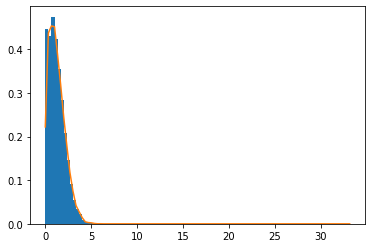

Histogram for F Test feature  8


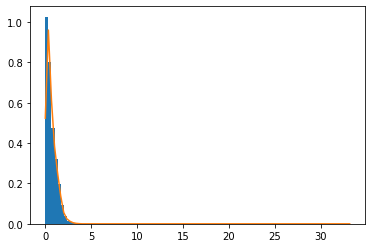

Histogram for F Test feature  9


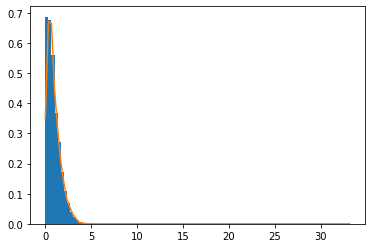

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.962775
LR Accuracy on test data - All features:  0.70425
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.958275
Logistic Regression Accuracy on test data:  0.7599
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.96115
Logistic Regression Accuracy on test data:  0.6925
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9631
Logistic Regression Accuracy on test data:  0.70885
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.962975
Logistic Regression Accuracy on test data:  0.70405
Accuracy for without feature  4
Logistic Regression Accuracy within training data:  0.953275
Logistic Regression Accuracy on test data:  0.5931
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.94335
Logistic Regression Accuracy on test data:  0.4437
Accuracy for without feature  6
Logistic Regression Accuracy within training data:  0.9588


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy on test data:  0.6712
Accuracy for without feature  7
Logistic Regression Accuracy within training data:  0.963
Logistic Regression Accuracy on test data:  0.69465
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.96225
Logistic Regression Accuracy on test data:  0.69825
Accuracy for without feature  9
Logistic Regression Accuracy within training data:  0.961725
Logistic Regression Accuracy on test data:  0.694




Results for lamda  1



array([-7.52816688e+00, -3.75643992e+00, -2.21501565e+00, -1.52900593e+00,
       -1.21856443e+00, -1.18413990e+00, -8.31846016e-01, -6.78535113e-01,
       -4.76140379e-01, -3.02779044e-01, -2.09034757e-01, -1.65539403e-01,
       -9.13953494e-02, -5.61336224e-02, -4.27993754e-02, -2.51606500e-02,
       -2.07345376e-02, -1.24787826e-02, -6.65068917e-03, -3.48822033e-03,
       -1.76643571e-15,  1.60615711e-04,  1.70102388e-03,  3.60003285e-03,
        7.30031443e-03,  1.29030614e-02,  1.74290527e-02,  2.54746285e-02,
        2.55367184e-02,  2.87583633e-02,  3.69937007e-02,  3.88926365e-02,
        5.38378531e-02,  5.94805124e-02,  6.96625732e-02,  8.14446514e-02,
        8.84034134e-02,  1.03750503e-01,  1.10650104e-01,  1.25496842e-01,
        1.35716205e-01,  1.69741050e-01,  2.90810267e-01,  3.46362040e-01,
        6.16982673e-01,  8.07168597e-01,  1.10760619e+00,  1.79883134e+00,
        3.24789214e+00,  1.36859669e+02])

array([[-0.17799007,  0.05097628,  0.04143481, ...,  0.2098112 ,
        -0.15287603,  0.09243455],
       [ 0.07062137,  0.03472332, -0.09889907, ..., -0.06054147,
        -0.1887016 ,  0.23167975],
       [-0.0021808 ,  0.00549617,  0.14207081, ...,  0.3569203 ,
         0.28009669,  0.07509387],
       ...,
       [-0.34732   ,  0.12275564, -0.221881  , ..., -0.28861133,
        -0.17897624,  0.04609443],
       [ 0.10881597, -0.12461496,  0.07882482, ..., -0.04252618,
        -0.17735628,  0.17639129],
       [-0.17578679, -0.15636525, -0.0725999 , ..., -0.00704988,
         0.05111667,  0.02005377]])

Printing least k eigenvalues before removing the zero eigenvalue
[-7.52816688 -3.75643992 -2.21501565 -1.52900593 -1.21856443 -1.1841399
 -0.83184602 -0.67853511 -0.47614038 -0.30277904]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-7.52816688 -3.75643992 -2.21501565 -1.52900593 -1.21856443 -1.1841399
 -0.83184602 -0.67853511 -0.47614038]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.438054,0.079413,1.966526,2.867110,0.159209,0.193394,0.463680,0.062012,1.186341,1.189403
1,7.417415,0.686786,1.598238,3.048050,1.173033,0.118512,0.183085,0.167485,1.092945,0.731848
2,12.806093,0.339918,3.041435,1.275935,0.105828,0.877489,0.824152,0.339838,1.646246,0.308380
3,12.231457,0.841560,6.240110,2.735003,0.085275,3.650691,0.444715,0.347386,1.732669,0.253437
4,18.430882,1.866474,5.010794,0.989607,0.159497,2.519049,1.866531,0.048703,2.200098,1.215174


Histogram for F Test feature  0


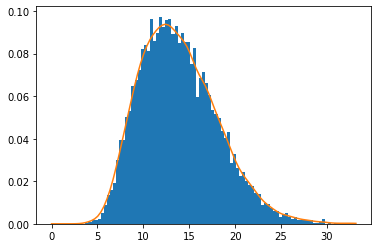

Histogram for F Test feature  1


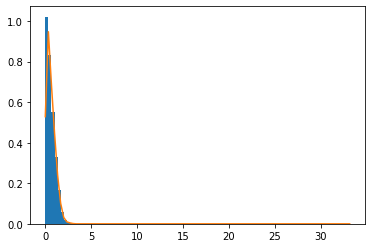

Histogram for F Test feature  2


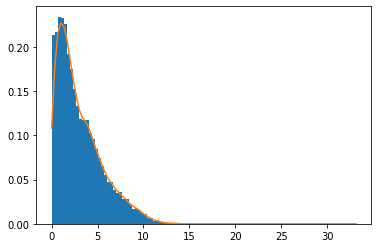

Histogram for F Test feature  3


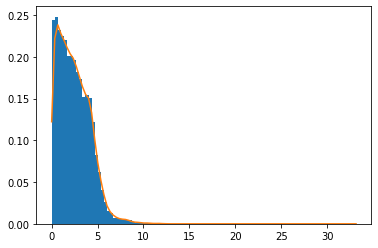

Histogram for F Test feature  4


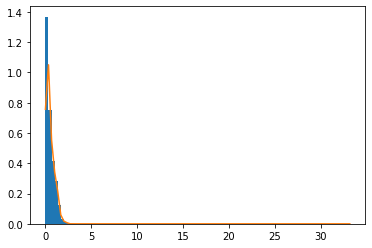

Histogram for F Test feature  5


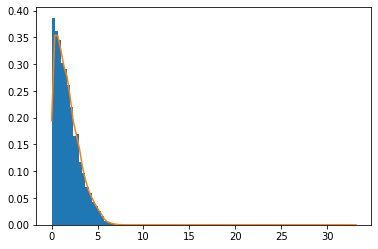

Histogram for F Test feature  6


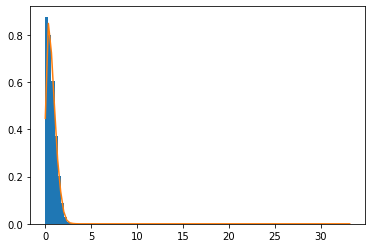

Histogram for F Test feature  7


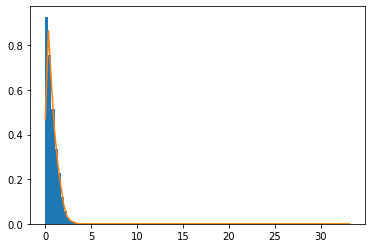

Histogram for F Test feature  8


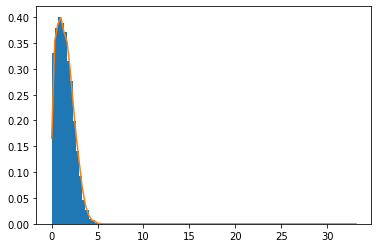

Histogram for F Test feature  9


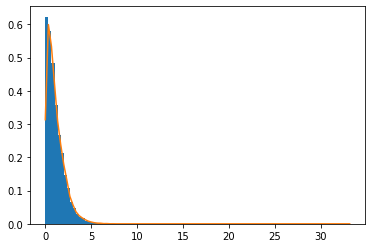

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.966075
LR Accuracy on test data - All features:  0.74075
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9605
Logistic Regression Accuracy on test data:  0.7929
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.964325
Logistic Regression Accuracy on test data:  0.7229
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.966075
Logistic Regression Accuracy on test data:  0.7462
Accuracy for without feature  3
Logistic Regression Accuracy within training data:  0.9656
Logistic Regression Accuracy on test data:  0.7382
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.930525
Logistic Regression Accuracy on test data:  0.2432
Accuracy for without feature  5
Logistic Regression Accuracy within training data:  0.966125
Logistic Regression Accuracy on test data:  0.74125
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.961825
Logistic Regression Accuracy on test data:  0.71635
Accuracy for without feature  7
Logistic Regression Accuracy within training data:  0.9598
Logistic Regression Accuracy on test data:  0.65565
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.966075
Logistic Regression Accuracy on test data:  0.74355
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.96565
Logistic Regression Accuracy on test data:  0.7388




Results for lamda  0.1



array([-8.30883246e+01, -3.96983481e+00, -2.58201648e+00, -2.28367030e+00,
       -1.87279394e+00, -1.41059259e+00, -1.29458326e+00, -9.34281899e-01,
       -8.31469361e-01, -6.22320683e-01, -5.62573921e-01, -3.41120513e-01,
       -2.88122736e-01, -2.46549489e-01, -2.09399241e-01, -2.03278146e-01,
       -1.84128240e-01, -1.02970024e-01, -9.88858826e-02, -8.59546470e-02,
       -7.03807759e-02, -6.52607331e-02, -5.40473479e-02, -5.12171390e-02,
       -4.76147880e-02, -4.20390060e-02, -3.93395363e-02, -3.26791823e-02,
       -2.71788865e-02, -2.22107745e-02, -2.00513687e-02, -1.78327714e-02,
       -1.37416306e-02, -1.30094471e-02, -1.14259447e-02, -8.99518116e-03,
       -6.53930760e-03, -6.35126696e-03, -5.14276933e-03, -4.11213642e-03,
       -3.72145741e-03, -2.83636510e-03, -1.79774296e-03, -8.61134780e-04,
       -4.57506046e-15,  5.39699725e-03,  1.57204418e-02,  4.37792503e-02,
        1.37503937e-01,  1.03693202e+00])

array([[-0.15278851,  0.06539712,  0.02327838, ..., -0.00206809,
         0.08082975,  0.11052652],
       [-0.17987711,  0.0543818 , -0.1186449 , ..., -0.19551479,
        -0.12967987, -0.16751742],
       [-0.06092287, -0.00637222, -0.01917619, ...,  0.01975128,
         0.3116116 , -0.09668147],
       ...,
       [-0.17123623,  0.13328295, -0.2983438 , ...,  0.1117912 ,
        -0.3392822 ,  0.20551101],
       [-0.12214453, -0.11128356,  0.05611279, ..., -0.07958909,
        -0.23257038, -0.16485619],
       [-0.0865995 , -0.16056405, -0.06748653, ...,  0.14492051,
        -0.01625959,  0.13312963]])

Printing least k eigenvalues before removing the zero eigenvalue
[-83.0883246   -3.96983481  -2.58201648  -2.2836703   -1.87279394
  -1.41059259  -1.29458326  -0.9342819   -0.83146936  -0.62232068]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-83.0883246   -3.96983481  -2.58201648  -2.2836703   -1.87279394
  -1.41059259  -1.29458326  -0.9342819   -0.83146936]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.438054,0.280154,1.930479,2.186035,1.613894,0.876538,0.122213,0.532094,1.496403,0.107772
1,7.417415,0.039132,1.522994,2.411916,2.173315,0.900051,0.019033,0.784166,1.257671,0.040675
2,12.806093,0.745049,3.042663,0.974769,0.850295,0.140014,0.778552,0.802683,1.829392,0.444338
3,12.231457,0.040008,6.269844,2.071144,1.514278,1.454985,2.886938,2.509800,1.235060,0.629541
4,18.430882,2.182976,4.864682,0.889370,0.926203,0.028106,2.659498,1.828610,1.251412,2.306397


Histogram for F Test feature  0


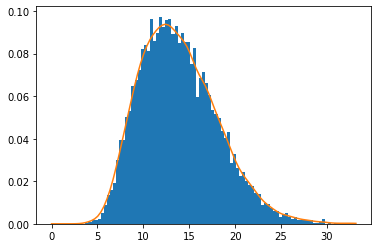

Histogram for F Test feature  1


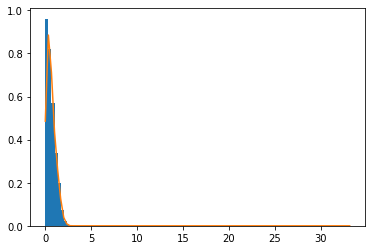

Histogram for F Test feature  2


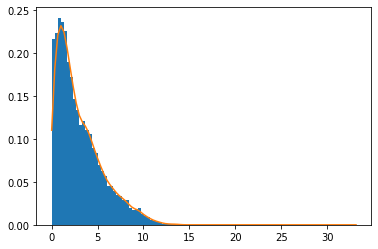

Histogram for F Test feature  3


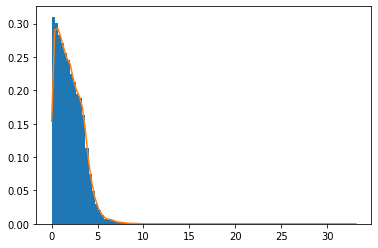

Histogram for F Test feature  4


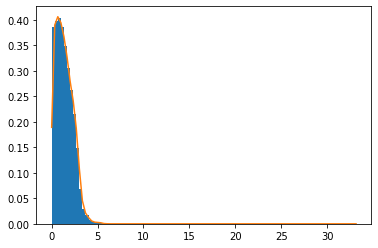

Histogram for F Test feature  5


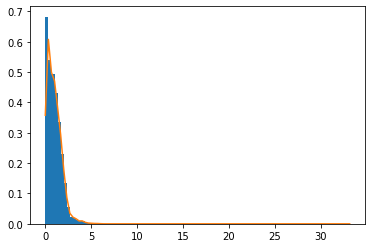

Histogram for F Test feature  6


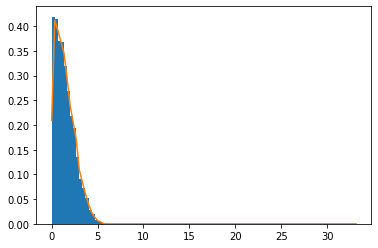

Histogram for F Test feature  7


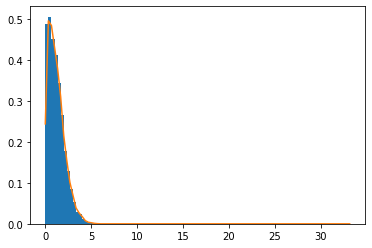

Histogram for F Test feature  8


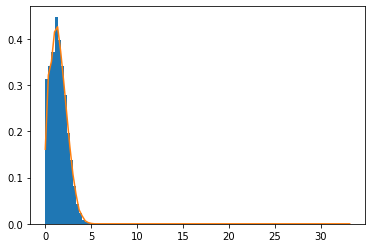

Histogram for F Test feature  9


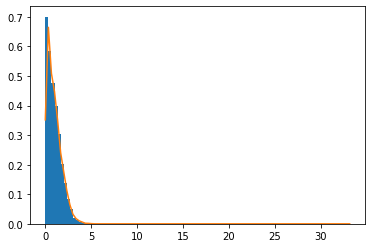

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.9701
LR Accuracy on test data - All features:  0.77895
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.96225
Logistic Regression Accuracy on test data:  0.8259
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.969625
Logistic Regression Accuracy on test data:  0.77805
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.969875
Logistic Regression Accuracy on test data:  0.782
Accuracy for without feature  3
Logistic Regression Accuracy within training data:  0.95405
Logistic Regression Accuracy on test data:  0.5735
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.937775
Logistic Regression Accuracy on test data:  0.29305
Accuracy for without feature  5
Logistic Regression Accuracy within training data:  0.969275
Logistic Regression Accuracy on test data:  0.7715
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.967675
Logistic Regression Accuracy on test data:  0.74645
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.960775
Logistic Regression Accuracy on test data:  0.6892
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.970075
Logistic Regression Accuracy on test data:  0.77795
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.970175
Logistic Regression Accuracy on test data:  0.77835




Results for lamda  0.01



array([-1.03062506e+02, -3.99659834e+00, -2.68476352e+00, -2.38875546e+00,
       -1.95753161e+00, -1.46047587e+00, -1.35130374e+00, -1.10489958e+00,
       -9.06365202e-01, -6.72269352e-01, -6.45071076e-01, -4.35648622e-01,
       -3.18841327e-01, -2.79829241e-01, -2.59771186e-01, -2.36706655e-01,
       -2.13990495e-01, -1.36075764e-01, -1.25685822e-01, -1.02791737e-01,
       -9.04876690e-02, -8.40597602e-02, -7.77436297e-02, -6.86469673e-02,
       -6.52121028e-02, -5.80173924e-02, -5.67829727e-02, -4.64605240e-02,
       -4.23941516e-02, -3.26964863e-02, -3.00646694e-02, -2.78946667e-02,
       -2.49104562e-02, -2.14902841e-02, -1.99216419e-02, -1.94272380e-02,
       -1.73183796e-02, -1.57015565e-02, -1.27076034e-02, -1.10820423e-02,
       -9.16377964e-03, -8.11333959e-03, -7.71893225e-03, -7.38412359e-03,
       -6.47888998e-03, -5.97321462e-03, -4.78224014e-03, -3.38695547e-03,
        1.67220661e-16,  2.79645413e-02])

array([[-0.14639698,  0.06874706,  0.00244797, ..., -0.01745149,
         0.10853906, -0.11131054],
       [-0.18818578,  0.05796067, -0.11542727, ..., -0.01879929,
        -0.21126029,  0.02737658],
       [-0.06317903, -0.00915894, -0.07360334, ..., -0.0264962 ,
        -0.05900388,  0.13081726],
       ...,
       [-0.1565295 ,  0.13537417, -0.3211581 , ...,  0.12355462,
        -0.08611997, -0.27510702],
       [-0.13030809, -0.10900669,  0.05455492, ...,  0.6210164 ,
         0.23624797,  0.19048393],
       [-0.07877894, -0.16103214, -0.08788896, ..., -0.01362807,
         0.00766793, -0.11549839]])

Printing least k eigenvalues before removing the zero eigenvalue
[-103.0625063    -3.99659834   -2.68476352   -2.38875546   -1.95753161
   -1.46047587   -1.35130374   -1.10489958   -0.9063652    -0.67226935]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-103.0625063    -3.99659834   -2.68476352   -2.38875546   -1.95753161
   -1.46047587   -1.35130374   -1.10489958   -0.9063652 ]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.438054,0.284284,1.926930,1.830961,1.888984,1.104100,0.428722,0.585064,1.242692,0.786670
1,7.417415,0.075891,1.505077,2.073737,2.401787,1.186091,0.238633,0.828356,0.812300,0.718413
2,12.806093,0.742780,3.043204,0.799990,0.986292,0.293867,0.454404,1.065447,1.156592,1.392751
3,12.231457,0.073011,6.272644,1.766879,1.675721,1.729638,2.121818,3.153399,0.715128,1.169403
4,18.430882,2.129327,4.839281,0.828112,0.954383,0.337573,2.302453,2.425044,0.126976,2.464095


Histogram for F Test feature  0


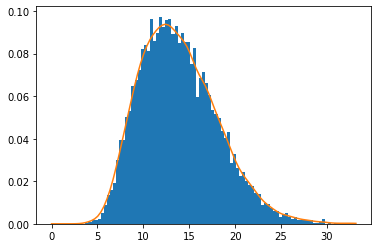

Histogram for F Test feature  1


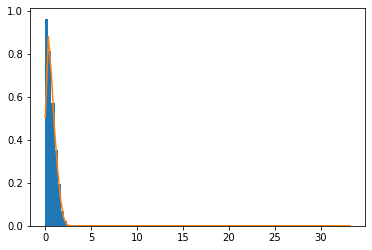

Histogram for F Test feature  2


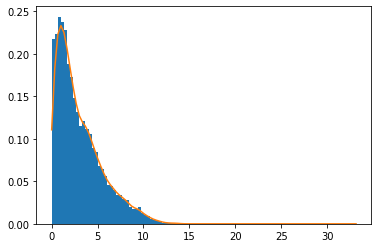

Histogram for F Test feature  3


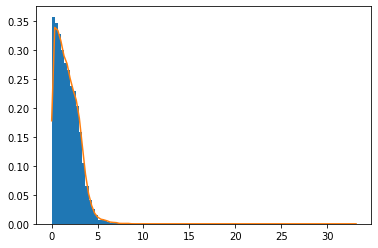

Histogram for F Test feature  4


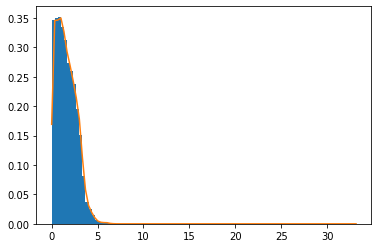

Histogram for F Test feature  5


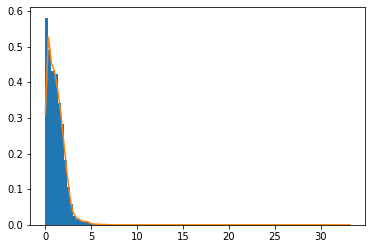

Histogram for F Test feature  6


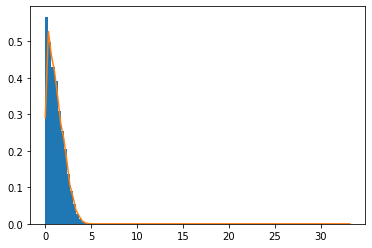

Histogram for F Test feature  7


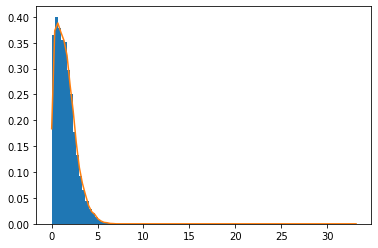

Histogram for F Test feature  8


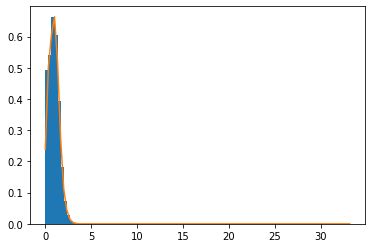

Histogram for F Test feature  9


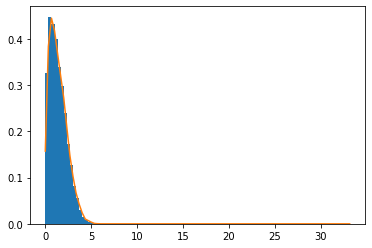

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.970875
LR Accuracy on test data - All features:  0.787
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.962625
Logistic Regression Accuracy on test data:  0.8325
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.970625
Logistic Regression Accuracy on test data:  0.78605
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.971
Logistic Regression Accuracy on test data:  0.78835
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.949525
Logistic Regression Accuracy on test data:  0.5046
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9392
Logistic Regression Accuracy on test data:  0.3657
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97045
Logistic Regression Accuracy on test data:  0.78465
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9666
Logistic Regression Accuracy on test data:  0.7348
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.964975
Logistic Regression Accuracy on test data:  0.73375
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9696
Logistic Regression Accuracy on test data:  0.7658
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9706
Logistic Regression Accuracy on test data:  0.7875




Results for lamda  0.001



array([-1.05083896e+02, -3.99937910e+00, -2.69704625e+00, -2.39954314e+00,
       -1.96621430e+00, -1.46777003e+00, -1.35729903e+00, -1.12570780e+00,
       -9.10805855e-01, -6.81337099e-01, -6.54781975e-01, -4.44853035e-01,
       -3.23479237e-01, -2.83564684e-01, -2.65778492e-01, -2.39446035e-01,
       -2.21392168e-01, -1.41830657e-01, -1.29070123e-01, -1.09554745e-01,
       -1.04912842e-01, -8.89338248e-02, -8.06984479e-02, -7.46555737e-02,
       -6.75610416e-02, -5.95154206e-02, -5.84061227e-02, -4.76659358e-02,
       -4.56321596e-02, -3.41521357e-02, -3.26689096e-02, -2.96165335e-02,
       -2.89806687e-02, -2.33415571e-02, -2.18620365e-02, -2.11119012e-02,
       -1.86532666e-02, -1.72192692e-02, -1.41410204e-02, -1.26859509e-02,
       -1.13759544e-02, -9.83790435e-03, -8.40731919e-03, -7.86057383e-03,
       -7.67939140e-03, -7.07925194e-03, -6.46687828e-03, -4.97996130e-03,
       -3.68732812e-03,  6.18430436e-16])

array([[-1.45868689e-01,  6.91293459e-02,  2.72862932e-04, ...,
         7.43894521e-03,  8.03980479e-03, -1.08539060e-01],
       [-1.88830519e-01,  5.83522185e-02,  1.14622472e-01, ...,
         1.90062772e-02,  9.54819720e-03,  2.11260292e-01],
       [-6.33542658e-02, -9.46607892e-03,  7.89901076e-02, ...,
        -4.98909012e-02,  1.82861367e-02,  5.90038783e-02],
       ...,
       [-1.55335528e-01,  1.35617908e-01,  3.23632987e-01, ...,
         6.65964133e-02, -4.51702608e-02,  8.61199698e-02],
       [-1.30946812e-01, -1.08761324e-01, -5.45503972e-02, ...,
         3.55594924e-02, -6.06962063e-01, -2.36247972e-01],
       [-7.81440265e-02, -1.61072466e-01,  9.04951933e-02, ...,
         2.55081792e-02,  1.31038531e-02, -7.66792879e-03]])

Printing least k eigenvalues before removing the zero eigenvalue
[-105.08389641   -3.9993791    -2.69704625   -2.39954314   -1.9662143
   -1.46777003   -1.35729903   -1.1257078    -0.91080586   -0.6813371 ]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-105.08389641   -3.9993791    -2.69704625   -2.39954314   -1.9662143
   -1.46777003   -1.35729903   -1.1257078    -0.91080586]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.438054,0.284587,1.926558,1.789851,1.913477,1.128162,0.473712,0.585511,1.209742,0.806864
1,7.417415,0.078823,1.503009,2.035452,2.422240,1.216908,0.273814,0.826684,0.763614,0.738881
2,12.806093,0.742515,3.043242,0.780105,0.997722,0.310642,0.403945,1.092624,1.109449,1.417247
3,12.231457,0.075632,6.272923,1.732483,1.688522,1.758257,2.005773,3.222206,0.699315,1.174850
4,18.430882,2.124792,4.836439,0.823484,0.954638,0.371212,2.245092,2.496868,0.166392,2.444257


Histogram for F Test feature  0


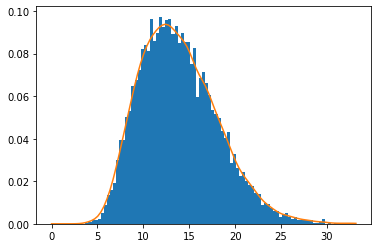

Histogram for F Test feature  1


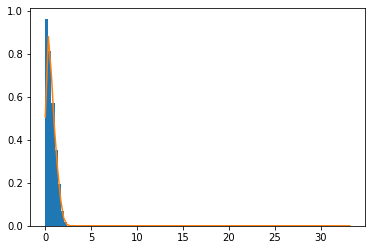

Histogram for F Test feature  2


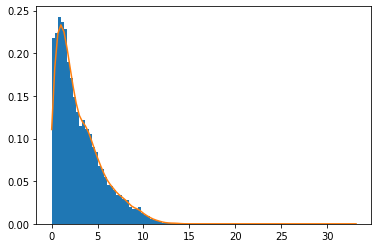

Histogram for F Test feature  3


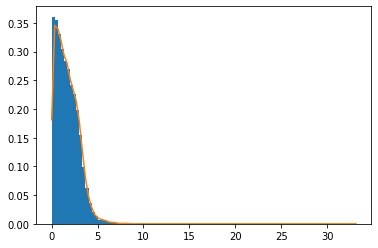

Histogram for F Test feature  4


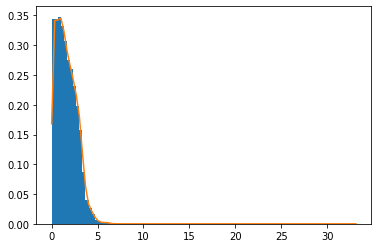

Histogram for F Test feature  5


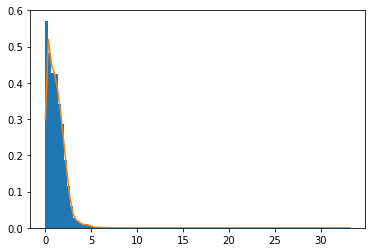

Histogram for F Test feature  6


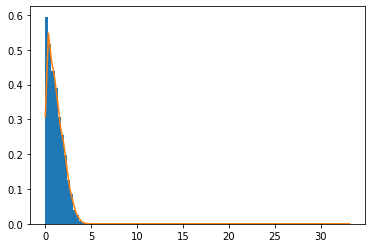

Histogram for F Test feature  7


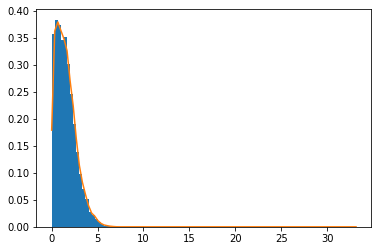

Histogram for F Test feature  8


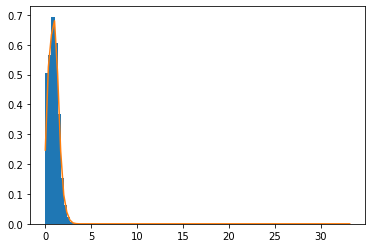

Histogram for F Test feature  9


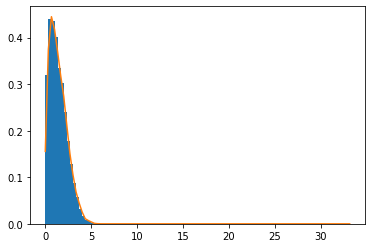

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.970925
LR Accuracy on test data - All features:  0.78745
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.96265
Logistic Regression Accuracy on test data:  0.83305
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.970925
Logistic Regression Accuracy on test data:  0.78615
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97105
Logistic Regression Accuracy on test data:  0.78895
Accuracy for without feature  3
Logistic Regression Accuracy within training data:  0.948975
Logistic Regression Accuracy on test data:  0.496
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.939675
Logistic Regression Accuracy on test data:  0.3758
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.970675
Logistic Regression Accuracy on test data:  0.7854
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9665
Logistic Regression Accuracy on test data:  0.7331
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.965675
Logistic Regression Accuracy on test data:  0.7391
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9694
Logistic Regression Accuracy on test data:  0.7628
Accuracy for without feature  9
Logistic Regression Accuracy within training data:  0.9706
Logistic Regression Accuracy on test data:  0.7886




Results for lamda  0.0001



array([-1.05286227e+02, -3.99965833e+00, -2.69829737e+00, -2.40062375e+00,
       -1.96708465e+00, -1.46853566e+00, -1.35790201e+00, -1.12778664e+00,
       -9.11240830e-01, -6.82432343e-01, -6.55668154e-01, -4.45764335e-01,
       -3.23977981e-01, -2.83968321e-01, -2.66407638e-01, -2.39718755e-01,
       -2.22342724e-01, -1.42647152e-01, -1.29548246e-01, -1.12017644e-01,
       -1.05149107e-01, -8.92010984e-02, -8.11752440e-02, -7.52799147e-02,
       -6.77750018e-02, -5.96619363e-02, -5.85577230e-02, -4.79146726e-02,
       -4.59566400e-02, -3.43242820e-02, -3.30128288e-02, -2.99383925e-02,
       -2.94181951e-02, -2.36045966e-02, -2.20684210e-02, -2.12461387e-02,
       -1.88704434e-02, -1.73653164e-02, -1.45144589e-02, -1.28205615e-02,
       -1.20860300e-02, -9.98628235e-03, -8.69444980e-03, -8.28341746e-03,
       -7.70723368e-03, -7.16347686e-03, -6.64918043e-03, -5.01548005e-03,
       -3.70963349e-03, -3.43116143e-16])

array([[-1.45816798e-01,  6.91681163e-02,  5.51182827e-04, ...,
         7.07119432e-03,  7.19218764e-03, -1.08539060e-01],
       [-1.88893522e-01,  5.83917473e-02,  1.14536096e-01, ...,
         1.86133678e-02,  9.00822539e-03,  2.11260292e-01],
       [-6.33713906e-02, -9.49709795e-03,  7.95236267e-02, ...,
        -4.85772942e-02,  1.87516120e-02,  5.90038783e-02],
       ...,
       [-1.55218419e-01,  1.35642698e-01,  3.23881205e-01, ...,
         5.52455802e-02, -4.57657104e-02,  8.61199698e-02],
       [-1.31009270e-01, -1.08736595e-01, -5.45516761e-02, ...,
         4.09611404e-02, -6.04204965e-01, -2.36247972e-01],
       [-7.80817527e-02, -1.61076407e-01,  9.07606199e-02, ...,
         2.18708651e-02,  1.16469011e-02, -7.66792879e-03]])

Printing least k eigenvalues before removing the zero eigenvalue
[-105.28622679   -3.99965833   -2.69829737   -2.40062375   -1.96708465
   -1.46853566   -1.35790201   -1.12778664   -0.91124083   -0.68243234]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-105.28622679   -3.99965833   -2.69829737   -2.40062375   -1.96708465
   -1.46853566   -1.35790201   -1.12778664   -0.91124083]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.438054,0.284616,1.926521,1.785698,1.915874,1.130579,0.478366,0.585458,1.206391,0.808622
1,7.417415,0.079111,1.502799,2.031596,2.424242,1.220006,0.277404,0.826411,0.758763,0.740633
2,12.806093,0.742489,3.043246,0.778101,0.998833,0.312332,0.398694,1.095296,1.104927,1.419373
3,12.231457,0.075888,6.272951,1.729015,1.689753,1.761124,1.993719,3.229008,0.697959,1.175183
4,18.430882,2.124345,4.836151,0.823049,0.954637,0.374598,2.239105,2.504121,0.169733,2.442257


Histogram for F Test feature  0


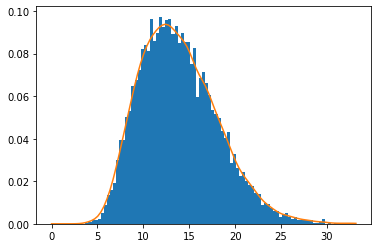

Histogram for F Test feature  1


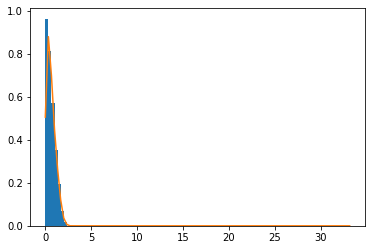

Histogram for F Test feature  2


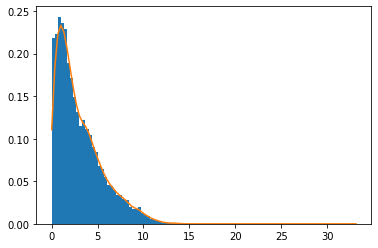

Histogram for F Test feature  3


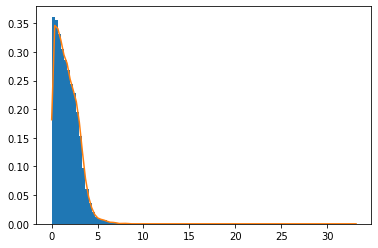

Histogram for F Test feature  4


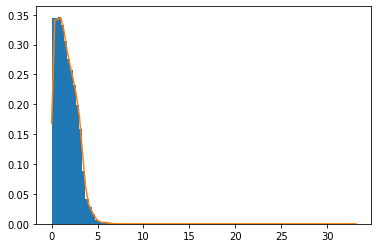

Histogram for F Test feature  5


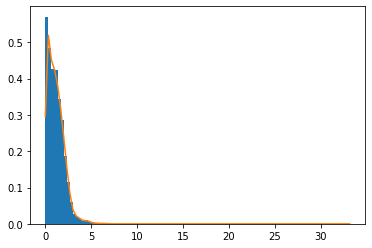

Histogram for F Test feature  6


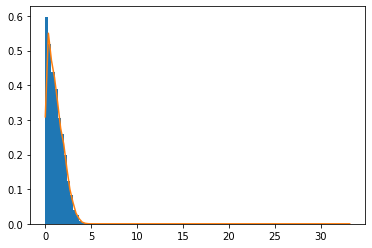

Histogram for F Test feature  7


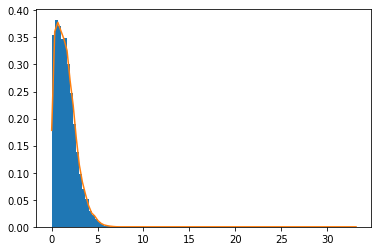

Histogram for F Test feature  8


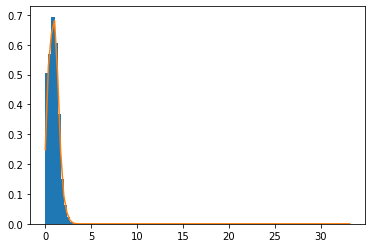

Histogram for F Test feature  9


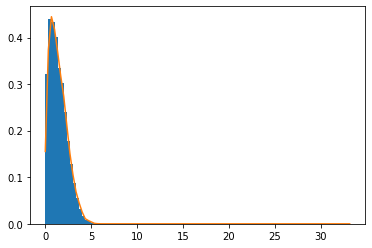

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.970925
LR Accuracy on test data - All features:  0.7876
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.96265
Logistic Regression Accuracy on test data:  0.8331
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.97095
Logistic Regression Accuracy on test data:  0.7864
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97105
Logistic Regression Accuracy on test data:  0.78895
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.948875
Logistic Regression Accuracy on test data:  0.49505
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.939725
Logistic Regression Accuracy on test data:  0.37665
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.970725
Logistic Regression Accuracy on test data:  0.78555
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.966475
Logistic Regression Accuracy on test data:  0.73315
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.96575
Logistic Regression Accuracy on test data:  0.7397
Accuracy for without feature  8
Logistic Regression Accuracy within training data:  0.969375
Logistic Regression Accuracy on test data:  0.7624
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.970575
Logistic Regression Accuracy on test data:  0.78855




Results for lamda  1e-05



array([-1.05306462e+02, -3.99968626e+00, -2.69842272e+00, -2.40073183e+00,
       -1.96717170e+00, -1.46861260e+00, -1.35796234e+00, -1.12799447e+00,
       -9.11284248e-01, -6.82544000e-01, -6.55755739e-01, -4.45855369e-01,
       -3.24028271e-01, -2.84009131e-01, -2.66470916e-01, -2.39746028e-01,
       -2.22440523e-01, -1.42733546e-01, -1.29598980e-01, -1.12262450e-01,
       -1.05172834e-01, -8.92273397e-02, -8.12265627e-02, -7.53406130e-02,
       -6.77962465e-02, -5.96765702e-02, -5.85727974e-02, -4.79425865e-02,
       -4.59872662e-02, -3.43419309e-02, -3.30485454e-02, -2.99798409e-02,
       -2.94537819e-02, -2.36314554e-02, -2.20887847e-02, -2.12593411e-02,
       -1.88942581e-02, -1.73797269e-02, -1.45587357e-02, -1.28340968e-02,
       -1.21539103e-02, -1.00003184e-02, -8.73641043e-03, -8.29833138e-03,
       -7.70979387e-03, -7.17043548e-03, -6.65993176e-03, -5.01846287e-03,
       -3.71174883e-03, -1.59096898e-15])

array([[-1.45811618e-01,  6.91719989e-02,  5.79076445e-04, ...,
         7.06341972e-03,  7.12116608e-03, -1.08539060e-01],
       [-1.88899808e-01,  5.83957040e-02,  1.14527399e-01, ...,
         1.85785082e-02,  8.96105210e-03,  2.11260292e-01],
       [-6.33730992e-02, -9.50020294e-03,  7.95769216e-02, ...,
        -4.84939291e-02,  1.87764956e-02,  5.90038783e-02],
       ...,
       [-1.55206731e-01,  1.35645182e-01,  3.23906033e-01, ...,
         5.45701705e-02, -4.57212115e-02,  8.61199698e-02],
       [-1.31015502e-01, -1.08734120e-01, -5.45518214e-02, ...,
         4.13076226e-02, -6.03993000e-01, -2.36247972e-01],
       [-7.80755372e-02, -1.61076800e-01,  9.07872091e-02, ...,
         2.16580188e-02,  1.15416038e-02, -7.66792879e-03]])

Printing least k eigenvalues before removing the zero eigenvalue
[-105.30646171   -3.99968626   -2.69842272   -2.40073183   -1.9671717
   -1.4686126    -1.35796234   -1.12799447   -0.91128425   -0.682544  ]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-105.30646171   -3.99968626   -2.69842272   -2.40073183   -1.9671717
   -1.4686126    -1.35796234   -1.12799447   -0.91128425]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.438054,0.284619,1.926517,1.785282,1.916113,1.130821,0.478833,0.585452,1.206055,0.808795
1,7.417415,0.079139,1.502778,2.031210,2.424442,1.220316,0.277763,0.826382,0.758278,0.740805
2,12.806093,0.742486,3.043246,0.777901,0.998943,0.312501,0.398166,1.095563,1.104477,1.419583
3,12.231457,0.075914,6.272953,1.728668,1.689876,1.761411,1.992510,3.229687,0.697826,1.175214
4,18.430882,2.124301,4.836122,0.823006,0.954636,0.374936,2.238504,2.504847,0.170062,2.442057


Histogram for F Test feature  0


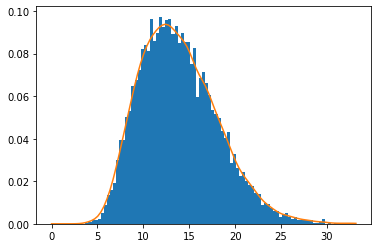

Histogram for F Test feature  1


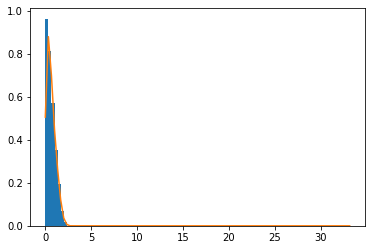

Histogram for F Test feature  2


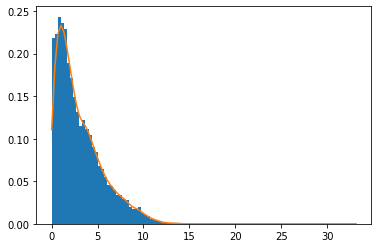

Histogram for F Test feature  3


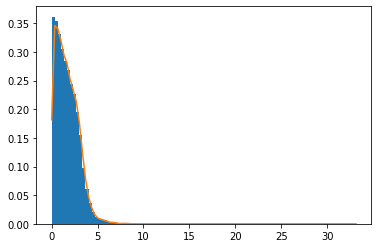

Histogram for F Test feature  4


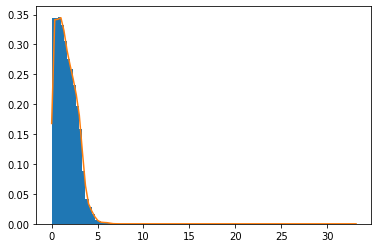

Histogram for F Test feature  5


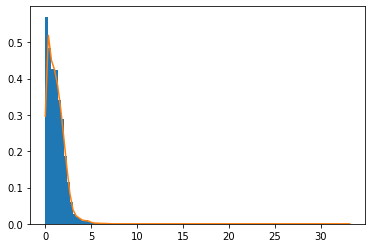

Histogram for F Test feature  6


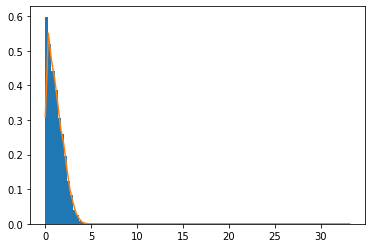

Histogram for F Test feature  7


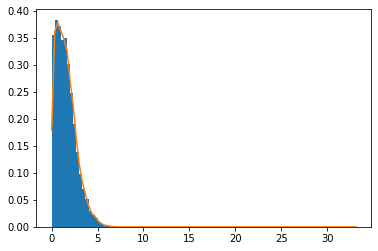

Histogram for F Test feature  8


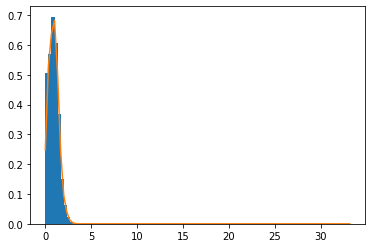

Histogram for F Test feature  9


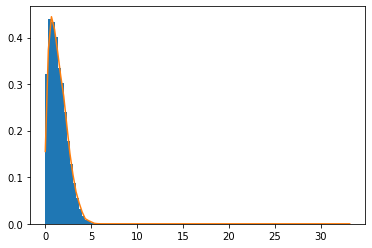

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.970925
LR Accuracy on test data - All features:  0.7876
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.962625
Logistic Regression Accuracy on test data:  0.8331
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.97095
Logistic Regression Accuracy on test data:  0.7864
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97105
Logistic Regression Accuracy on test data:  0.78895
Accuracy for without feature  3
Logistic Regression Accuracy within training data:  0.948875
Logistic Regression Accuracy on test data:  0.4949
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.939725
Logistic Regression Accuracy on test data:  0.3767
Accuracy for without feature  5
Logistic Regression Accuracy within training data:  0.97075
Logistic Regression Accuracy on test data:  0.78555
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.966475
Logistic Regression Accuracy on test data:  0.73315
Accuracy for without feature  7
Logistic Regression Accuracy within training data:  0.9658
Logistic Regression Accuracy on test data:  0.7399
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9694
Logistic Regression Accuracy on test data:  0.7623
Accuracy for without feature  9
Logistic Regression Accuracy within training data:  0.970575
Logistic Regression Accuracy on test data:  0.7886




Results for lamda  1e-06



/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([-1.05308485e+02, -3.99968906e+00, -2.69843525e+00, -2.40074264e+00,
       -1.96718041e+00, -1.46862030e+00, -1.35796838e+00, -1.12801526e+00,
       -9.11288589e-01, -6.82555188e-01, -6.55764487e-01, -4.45864472e-01,
       -3.24033304e-01, -2.84013216e-01, -2.66477248e-01, -2.39748755e-01,
       -2.22450331e-01, -1.42742237e-01, -1.29604086e-01, -1.12286905e-01,
       -1.05175208e-01, -8.92299596e-02, -8.12317329e-02, -7.53466630e-02,
       -6.77983695e-02, -5.96780334e-02, -5.85743040e-02, -4.79454102e-02,
       -4.59903082e-02, -3.43437004e-02, -3.30521312e-02, -2.99840848e-02,
       -2.94572490e-02, -2.36341458e-02, -2.20908183e-02, -2.12606593e-02,
       -1.88966619e-02, -1.73811657e-02, -1.45632330e-02, -1.28354541e-02,
       -1.21606183e-02, -1.00017147e-02, -8.74060041e-03, -8.29969058e-03,
       -7.71004927e-03, -7.17112284e-03, -6.66096911e-03, -5.01875783e-03,
       -3.71195948e-03,  3.25968807e-15])

array([[-1.45811100e-01,  6.91723872e-02,  5.81866422e-04, ...,
         7.06280838e-03,  7.11416047e-03, -1.08539060e-01],
       [-1.88900437e-01,  5.83960997e-02,  1.14526529e-01, ...,
         1.85750557e-02,  8.95638675e-03,  2.11260292e-01],
       [-6.33732700e-02, -9.50051346e-03,  7.95822505e-02, ...,
        -4.84858824e-02,  1.87788473e-02,  5.90038783e-02],
       ...,
       [-1.55205562e-01,  1.35645430e-01,  3.23908516e-01, ...,
         5.45053111e-02, -4.57161320e-02,  8.61199698e-02],
       [-1.31016126e-01, -1.08733872e-01, -5.45518361e-02, ...,
         4.13411341e-02, -6.03972246e-01, -2.36247972e-01],
       [-7.80749158e-02, -1.61076840e-01,  9.07898685e-02, ...,
         2.16376137e-02,  1.15313395e-02, -7.66792879e-03]])

Printing least k eigenvalues before removing the zero eigenvalue
[-105.30848522   -3.99968906   -2.69843525   -2.40074264   -1.96718041
   -1.4686203    -1.35796838   -1.12801526   -0.91128859   -0.68255519]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-105.30848522   -3.99968906   -2.69843525   -2.40074264   -1.96718041
   -1.4686203    -1.35796838   -1.12801526   -0.91128859]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.438054,0.284620,1.926517,1.785241,1.916137,1.130845,0.478879,0.585451,1.206021,0.808813
1,7.417415,0.079142,1.502776,2.031171,2.424462,1.220347,0.277799,0.826379,0.758230,0.740823
2,12.806093,0.742486,3.043246,0.777881,0.998955,0.312518,0.398114,1.095590,1.104432,1.419603
3,12.231457,0.075916,6.272954,1.728633,1.689888,1.761440,1.992389,3.229755,0.697813,1.175218
4,18.430882,2.124296,4.836120,0.823001,0.954636,0.374970,2.238444,2.504919,0.170094,2.442037


Histogram for F Test feature  0


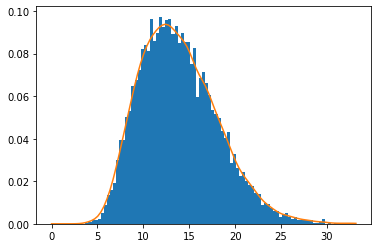

Histogram for F Test feature  1


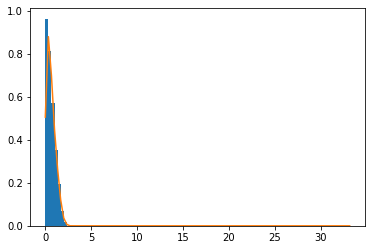

Histogram for F Test feature  2


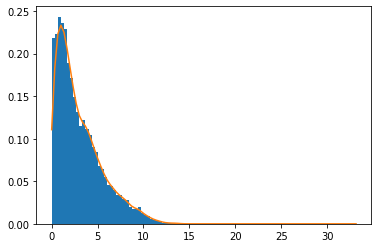

Histogram for F Test feature  3


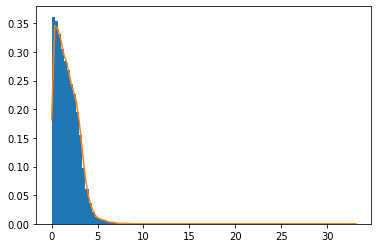

Histogram for F Test feature  4


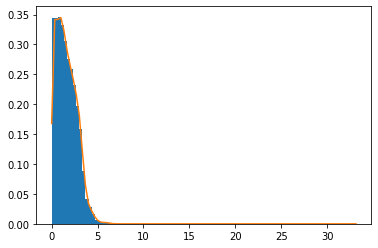

Histogram for F Test feature  5


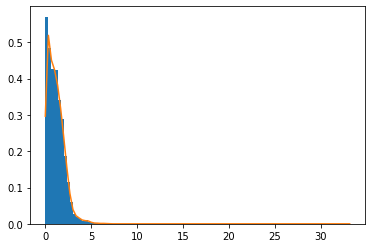

Histogram for F Test feature  6


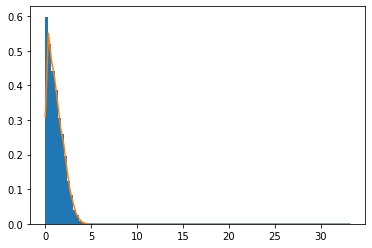

Histogram for F Test feature  7


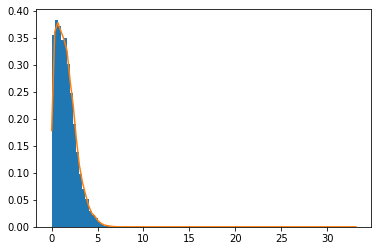

Histogram for F Test feature  8


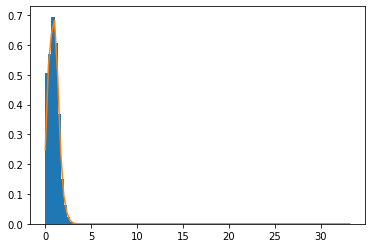

Histogram for F Test feature  9


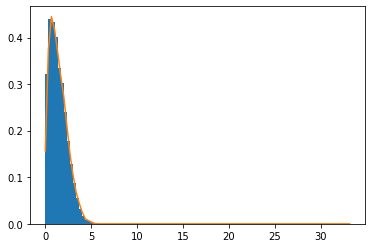

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.970925
LR Accuracy on test data - All features:  0.7876
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.962625
Logistic Regression Accuracy on test data:  0.8331
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.97095
Logistic Regression Accuracy on test data:  0.7864
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97105
Logistic Regression Accuracy on test data:  0.78895
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.948875
Logistic Regression Accuracy on test data:  0.4949
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.939725
Logistic Regression Accuracy on test data:  0.3767
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97075
Logistic Regression Accuracy on test data:  0.78555
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.966475
Logistic Regression Accuracy on test data:  0.73315
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9658
Logistic Regression Accuracy on test data:  0.7399
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9694
Logistic Regression Accuracy on test data:  0.7623
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.970575
Logistic Regression Accuracy on test data:  0.7886




Results for lamda  1e-07



array([-1.05308688e+02, -3.99968934e+00, -2.69843651e+00, -2.40074372e+00,
       -1.96718128e+00, -1.46862107e+00, -1.35796898e+00, -1.12801733e+00,
       -9.11289023e-01, -6.82556307e-01, -6.55765362e-01, -4.45865382e-01,
       -3.24033808e-01, -2.84013625e-01, -2.66477881e-01, -2.39749028e-01,
       -2.22451312e-01, -1.42743107e-01, -1.29604597e-01, -1.12289350e-01,
       -1.05175446e-01, -8.92302215e-02, -8.12322503e-02, -7.53472678e-02,
       -6.77985818e-02, -5.96781797e-02, -5.85744546e-02, -4.79456929e-02,
       -4.59906121e-02, -3.43438774e-02, -3.30524899e-02, -2.99845101e-02,
       -2.94575948e-02, -2.36344148e-02, -2.20910216e-02, -2.12607911e-02,
       -1.88969025e-02, -1.73813095e-02, -1.45636834e-02, -1.28355899e-02,
       -1.21612882e-02, -1.00018542e-02, -8.74101924e-03, -8.29982531e-03,
       -7.71007480e-03, -7.17119149e-03, -6.66107249e-03, -5.01878729e-03,
       -3.71198054e-03,  3.27626098e-16])

array([[-1.45811049e-01,  6.91724260e-02,  5.82145426e-04, ...,
         7.06274884e-03,  7.11346085e-03, -1.08539060e-01],
       [-1.88900500e-01,  5.83961393e-02,  1.14526442e-01, ...,
         1.85747108e-02,  8.95592072e-03,  2.11260292e-01],
       [-6.33732871e-02, -9.50054452e-03,  7.95827834e-02, ...,
        -4.84850805e-02,  1.87790812e-02,  5.90038783e-02],
       ...,
       [-1.55205445e-01,  1.35645455e-01,  3.23908764e-01, ...,
         5.44988508e-02, -4.57156180e-02,  8.61199698e-02],
       [-1.31016188e-01, -1.08733848e-01, -5.45518376e-02, ...,
         4.13444743e-02, -6.03970175e-01, -2.36247972e-01],
       [-7.80748537e-02, -1.61076844e-01,  9.07901345e-02, ...,
         2.16355817e-02,  1.15303157e-02, -7.66792879e-03]])

Printing least k eigenvalues before removing the zero eigenvalue
[-105.30868757   -3.99968934   -2.69843651   -2.40074372   -1.96718128
   -1.46862107   -1.35796898   -1.12801733   -0.91128902   -0.68255631]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-105.30868757   -3.99968934   -2.69843651   -2.40074372   -1.96718128
   -1.46862107   -1.35796898   -1.12801733   -0.91128902]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.438054,0.284620,1.926517,1.785237,1.916140,1.130848,0.478884,0.585451,1.206018,0.808815
1,7.417415,0.079142,1.502776,2.031168,2.424464,1.220350,0.277803,0.826379,0.758225,0.740824
2,12.806093,0.742486,3.043246,0.777879,0.998956,0.312520,0.398108,1.095592,1.104427,1.419606
3,12.231457,0.075917,6.272954,1.728630,1.689889,1.761442,1.992376,3.229761,0.697811,1.175218
4,18.430882,2.124296,4.836119,0.823001,0.954636,0.374974,2.238438,2.504927,0.170098,2.442035


Histogram for F Test feature  0


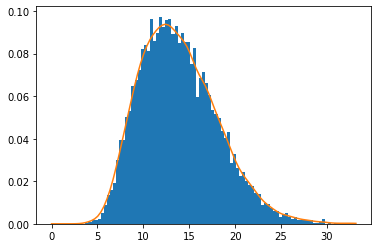

Histogram for F Test feature  1


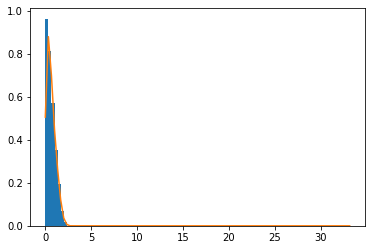

Histogram for F Test feature  2


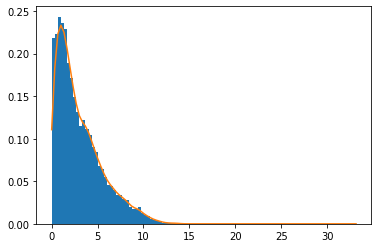

Histogram for F Test feature  3


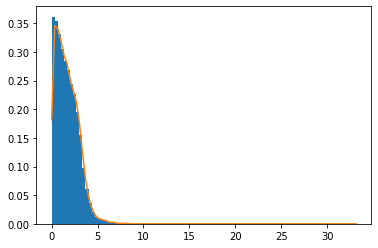

Histogram for F Test feature  4


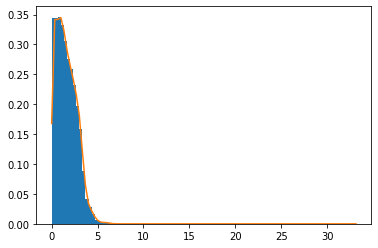

Histogram for F Test feature  5


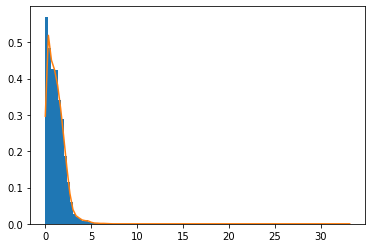

Histogram for F Test feature  6


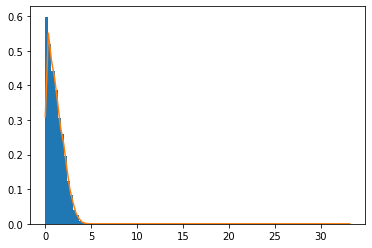

Histogram for F Test feature  7


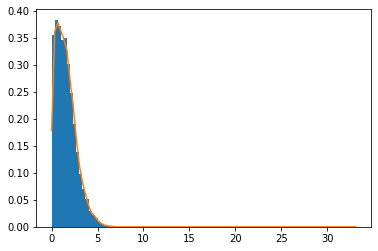

Histogram for F Test feature  8


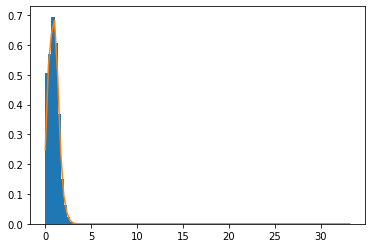

Histogram for F Test feature  9


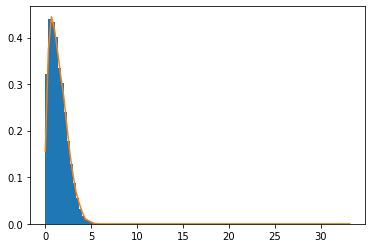

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.970925
LR Accuracy on test data - All features:  0.7876
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.962625
Logistic Regression Accuracy on test data:  0.8331
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.97095
Logistic Regression Accuracy on test data:  0.7864
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97105
Logistic Regression Accuracy on test data:  0.78895
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.948875
Logistic Regression Accuracy on test data:  0.4949
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.939725
Logistic Regression Accuracy on test data:  0.3767
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97075
Logistic Regression Accuracy on test data:  0.78555
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.966475
Logistic Regression Accuracy on test data:  0.73315
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9658
Logistic Regression Accuracy on test data:  0.7399
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9694
Logistic Regression Accuracy on test data:  0.7623
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.970575
Logistic Regression Accuracy on test data:  0.7886




Results for lamda  1e-08



array([-1.05308708e+02, -3.99968937e+00, -2.69843663e+00, -2.40074383e+00,
       -1.96718136e+00, -1.46862114e+00, -1.35796904e+00, -1.12801754e+00,
       -9.11289066e-01, -6.82556418e-01, -6.55765449e-01, -4.45865473e-01,
       -3.24033858e-01, -2.84013666e-01, -2.66477944e-01, -2.39749055e-01,
       -2.22451410e-01, -1.42743194e-01, -1.29604648e-01, -1.12289595e-01,
       -1.05175469e-01, -8.92302477e-02, -8.12323020e-02, -7.53473283e-02,
       -6.77986031e-02, -5.96781943e-02, -5.85744697e-02, -4.79457211e-02,
       -4.59906425e-02, -3.43438951e-02, -3.30525258e-02, -2.99845527e-02,
       -2.94576293e-02, -2.36344417e-02, -2.20910419e-02, -2.12608043e-02,
       -1.88969265e-02, -1.73813239e-02, -1.45637284e-02, -1.28356035e-02,
       -1.21613552e-02, -1.00018682e-02, -8.74106112e-03, -8.29983877e-03,
       -7.71007735e-03, -7.17119836e-03, -6.66108282e-03, -5.01879024e-03,
       -3.71198264e-03, -2.16629993e-16])

array([[-1.45811043e-01,  6.91724299e-02,  5.82173326e-04, ...,
         7.06274290e-03,  7.11339090e-03, -1.08539060e-01],
       [-1.88900506e-01,  5.83961432e-02,  1.14526433e-01, ...,
         1.85746763e-02,  8.95587412e-03,  2.11260292e-01],
       [-6.33732888e-02, -9.50054762e-03,  7.95828367e-02, ...,
        -4.84850003e-02,  1.87791046e-02,  5.90038783e-02],
       ...,
       [-1.55205434e-01,  1.35645457e-01,  3.23908789e-01, ...,
         5.44982051e-02, -4.57155666e-02,  8.61199698e-02],
       [-1.31016194e-01, -1.08733845e-01, -5.45518377e-02, ...,
         4.13448082e-02, -6.03969968e-01, -2.36247972e-01],
       [-7.80748475e-02, -1.61076844e-01,  9.07901611e-02, ...,
         2.16353785e-02,  1.15302133e-02, -7.66792879e-03]])

Printing least k eigenvalues before removing the zero eigenvalue
[-105.3087078    -3.99968937   -2.69843663   -2.40074383   -1.96718136
   -1.46862114   -1.35796904   -1.12801754   -0.91128907   -0.68255642]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-105.3087078    -3.99968937   -2.69843663   -2.40074383   -1.96718136
   -1.46862114   -1.35796904   -1.12801754   -0.91128907]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.438054,0.284620,1.926517,1.785236,1.916140,1.130848,0.478884,0.585451,1.206018,0.808815
1,7.417415,0.079142,1.502776,2.031167,2.424464,1.220350,0.277803,0.826379,0.758225,0.740825
2,12.806093,0.742486,3.043246,0.777878,0.998956,0.312520,0.398108,1.095593,1.104427,1.419606
3,12.231457,0.075917,6.272954,1.728629,1.689889,1.761443,1.992375,3.229762,0.697811,1.175218
4,18.430882,2.124296,4.836119,0.823001,0.954636,0.374974,2.238437,2.504927,0.170098,2.442035


Histogram for F Test feature  0


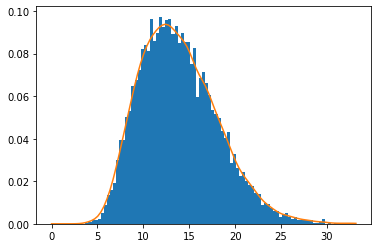

Histogram for F Test feature  1


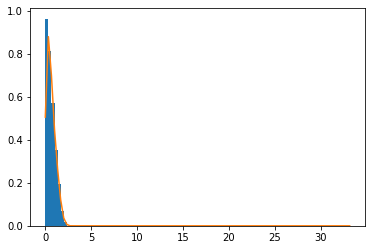

Histogram for F Test feature  2


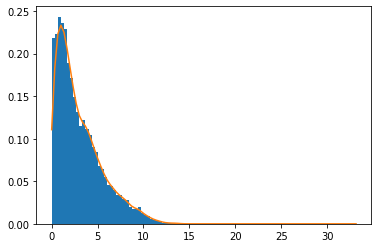

Histogram for F Test feature  3


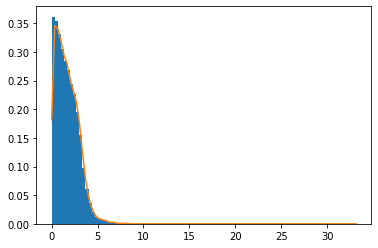

Histogram for F Test feature  4


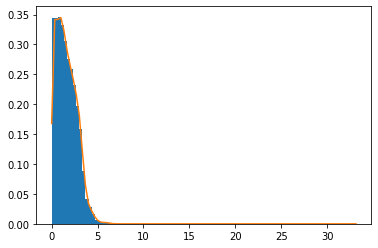

Histogram for F Test feature  5


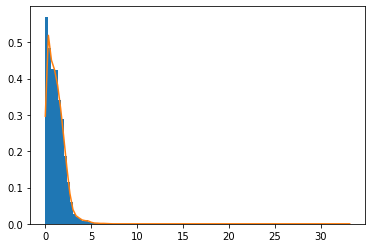

Histogram for F Test feature  6


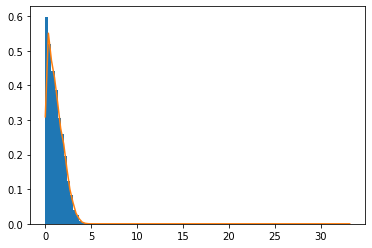

Histogram for F Test feature  7


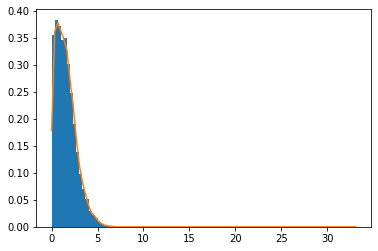

Histogram for F Test feature  8


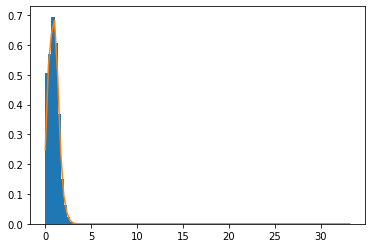

Histogram for F Test feature  9


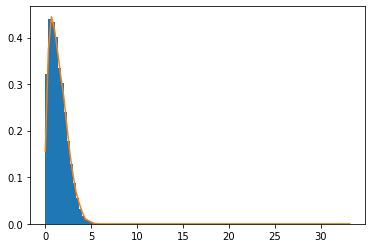

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.970925
LR Accuracy on test data - All features:  0.7876
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.962625
Logistic Regression Accuracy on test data:  0.8331
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.97095
Logistic Regression Accuracy on test data:  0.7864
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97105
Logistic Regression Accuracy on test data:  0.78895
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.948875
Logistic Regression Accuracy on test data:  0.4949
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.939725
Logistic Regression Accuracy on test data:  0.3767
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97075
Logistic Regression Accuracy on test data:  0.78555
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.966475
Logistic Regression Accuracy on test data:  0.73315
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9658
Logistic Regression Accuracy on test data:  0.7399
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9694
Logistic Regression Accuracy on test data:  0.7623
Accuracy for without feature  9
Logistic Regression Accuracy within training data:  0.970575
Logistic Regression Accuracy on test data:  0.7886




Results for lamda  1e-09



/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([-1.05308710e+02, -3.99968937e+00, -2.69843664e+00, -2.40074384e+00,
       -1.96718137e+00, -1.46862115e+00, -1.35796905e+00, -1.12801756e+00,
       -9.11289070e-01, -6.82556430e-01, -6.55765458e-01, -4.45865482e-01,
       -3.24033863e-01, -2.84013670e-01, -2.66477951e-01, -2.39749058e-01,
       -2.22451420e-01, -1.42743202e-01, -1.29604653e-01, -1.12289619e-01,
       -1.05175472e-01, -8.92302503e-02, -8.12323072e-02, -7.53473343e-02,
       -6.77986052e-02, -5.96781958e-02, -5.85744712e-02, -4.79457240e-02,
       -4.59906456e-02, -3.43438969e-02, -3.30525293e-02, -2.99845569e-02,
       -2.94576328e-02, -2.36344444e-02, -2.20910440e-02, -2.12608056e-02,
       -1.88969289e-02, -1.73813254e-02, -1.45637329e-02, -1.28356048e-02,
       -1.21613619e-02, -1.00018696e-02, -8.74106530e-03, -8.29984011e-03,
       -7.71007761e-03, -7.17119905e-03, -6.66108386e-03, -5.01879053e-03,
       -3.71198285e-03,  5.93781558e-17])

array([[-1.45811043e-01,  6.91724303e-02,  5.82176116e-04, ...,
         7.06274230e-03,  7.11338390e-03, -1.08539060e-01],
       [-1.88900507e-01,  5.83961436e-02,  1.14526432e-01, ...,
         1.85746728e-02,  8.95586946e-03,  2.11260292e-01],
       [-6.33732889e-02, -9.50054793e-03,  7.95828420e-02, ...,
        -4.84849923e-02,  1.87791069e-02,  5.90038783e-02],
       ...,
       [-1.55205433e-01,  1.35645458e-01,  3.23908791e-01, ...,
         5.44981405e-02, -4.57155614e-02,  8.61199698e-02],
       [-1.31016195e-01, -1.08733845e-01, -5.45518377e-02, ...,
         4.13448416e-02, -6.03969947e-01, -2.36247972e-01],
       [-7.80748468e-02, -1.61076844e-01,  9.07901637e-02, ...,
         2.16353582e-02,  1.15302031e-02, -7.66792879e-03]])

Printing least k eigenvalues before removing the zero eigenvalue
[-105.30870983   -3.99968937   -2.69843664   -2.40074384   -1.96718137
   -1.46862115   -1.35796905   -1.12801756   -0.91128907   -0.68255643]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-105.30870983   -3.99968937   -2.69843664   -2.40074384   -1.96718137
   -1.46862115   -1.35796905   -1.12801756   -0.91128907]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.438054,0.284620,1.926517,1.785236,1.916140,1.130848,0.478884,0.585451,1.206018,0.808815
1,7.417415,0.079143,1.502776,2.031167,2.424464,1.220350,0.277803,0.826379,0.758225,0.740825
2,12.806093,0.742486,3.043246,0.777878,0.998956,0.312520,0.398108,1.095593,1.104427,1.419606
3,12.231457,0.075917,6.272954,1.728629,1.689889,1.761443,1.992375,3.229762,0.697811,1.175218
4,18.430882,2.124296,4.836119,0.823001,0.954636,0.374974,2.238437,2.504927,0.170098,2.442035


Histogram for F Test feature  0


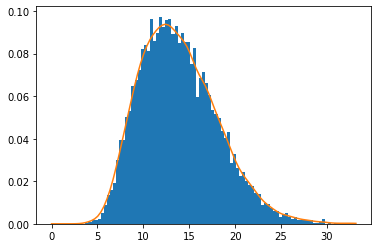

Histogram for F Test feature  1


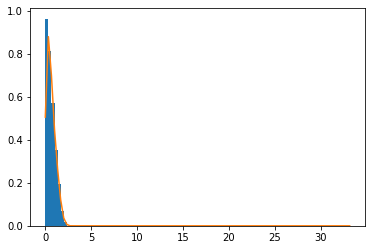

Histogram for F Test feature  2


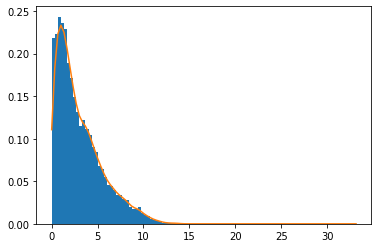

Histogram for F Test feature  3


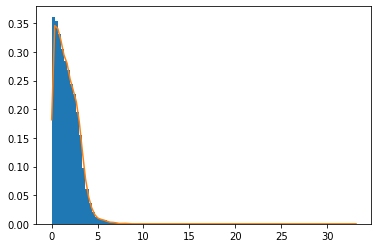

Histogram for F Test feature  4


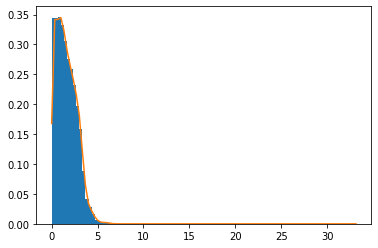

Histogram for F Test feature  5


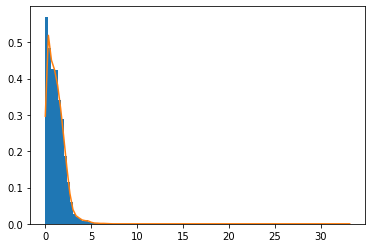

Histogram for F Test feature  6


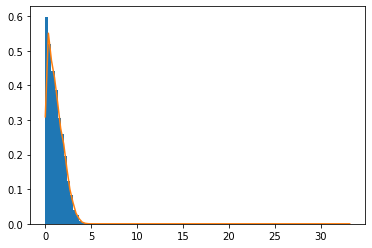

Histogram for F Test feature  7


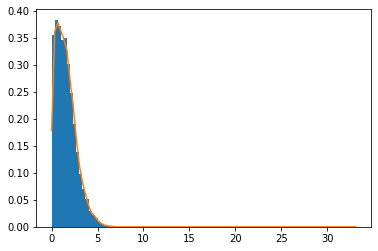

Histogram for F Test feature  8


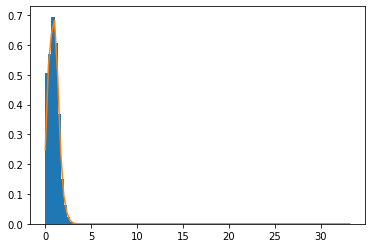

Histogram for F Test feature  9


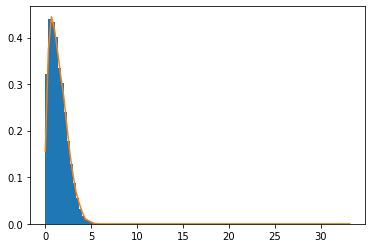

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy within training data - All features :  0.970925
LR Accuracy on test data - All features:  0.7876
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.962625
Logistic Regression Accuracy on test data:  0.8331
Accuracy for without feature  1
Logistic Regression Accuracy within training data:  0.97095
Logistic Regression Accuracy on test data:  0.7864
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97105
Logistic Regression Accuracy on test data:  0.78895
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.948875
Logistic Regression Accuracy on test data:  0.4949
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.939725
Logistic Regression Accuracy on test data:  0.3767
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97075
Logistic Regression Accuracy on test data:  0.78555
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.966475
Logistic Regression Accuracy on test data:  0.73315
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9658
Logistic Regression Accuracy on test data:  0.7399
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9694
Logistic Regression Accuracy on test data:  0.7623
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.970575
Logistic Regression Accuracy on test data:  0.7886




Results for lamda  1e-10



array([-1.05308710e+02, -3.99968937e+00, -2.69843665e+00, -2.40074384e+00,
       -1.96718137e+00, -1.46862115e+00, -1.35796905e+00, -1.12801756e+00,
       -9.11289071e-01, -6.82556431e-01, -6.55765459e-01, -4.45865483e-01,
       -3.24033864e-01, -2.84013670e-01, -2.66477951e-01, -2.39749058e-01,
       -2.22451421e-01, -1.42743203e-01, -1.29604653e-01, -1.12289622e-01,
       -1.05175472e-01, -8.92302506e-02, -8.12323077e-02, -7.53473350e-02,
       -6.77986054e-02, -5.96781959e-02, -5.85744713e-02, -4.79457242e-02,
       -4.59906459e-02, -3.43438971e-02, -3.30525297e-02, -2.99845574e-02,
       -2.94576331e-02, -2.36344447e-02, -2.20910442e-02, -2.12608057e-02,
       -1.88969292e-02, -1.73813255e-02, -1.45637334e-02, -1.28356050e-02,
       -1.21613626e-02, -1.00018697e-02, -8.74106572e-03, -8.29984025e-03,
       -7.71007763e-03, -7.17119911e-03, -6.66108396e-03, -5.01879056e-03,
       -3.71198287e-03, -1.49783796e-15])

array([[-1.45811043e-01,  6.91724303e-02,  5.82176395e-04, ...,
         7.06274224e-03,  7.11338320e-03, -1.08539060e-01],
       [-1.88900507e-01,  5.83961436e-02,  1.14526432e-01, ...,
         1.85746725e-02,  8.95586900e-03,  2.11260292e-01],
       [-6.33732890e-02, -9.50054796e-03,  7.95828426e-02, ...,
        -4.84849915e-02,  1.87791071e-02,  5.90038783e-02],
       ...,
       [-1.55205432e-01,  1.35645458e-01,  3.23908791e-01, ...,
         5.44981340e-02, -4.57155609e-02,  8.61199698e-02],
       [-1.31016195e-01, -1.08733845e-01, -5.45518377e-02, ...,
         4.13448450e-02, -6.03969945e-01, -2.36247972e-01],
       [-7.80748468e-02, -1.61076844e-01,  9.07901640e-02, ...,
         2.16353562e-02,  1.15302020e-02, -7.66792879e-03]])

Printing least k eigenvalues before removing the zero eigenvalue
[-105.30871003   -3.99968937   -2.69843665   -2.40074384   -1.96718137
   -1.46862115   -1.35796905   -1.12801756   -0.91128907   -0.68255643]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-105.30871003   -3.99968937   -2.69843665   -2.40074384   -1.96718137
   -1.46862115   -1.35796905   -1.12801756   -0.91128907]
Printing non zero indeces of the least k-1 eigenvalues
[0 1 2 3 4 5 6 7 8]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9
0,13.438054,0.284620,1.926517,1.785236,1.916140,1.130848,0.478884,0.585451,1.206018,0.808815
1,7.417415,0.079143,1.502776,2.031167,2.424464,1.220350,0.277803,0.826379,0.758225,0.740825
2,12.806093,0.742486,3.043246,0.777878,0.998956,0.312520,0.398108,1.095593,1.104427,1.419606
3,12.231457,0.075917,6.272954,1.728629,1.689889,1.761443,1.992375,3.229762,0.697811,1.175218
4,18.430882,2.124296,4.836119,0.823001,0.954636,0.374974,2.238437,2.504927,0.170098,2.442035


Histogram for F Test feature  0


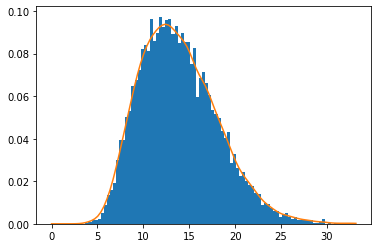

Histogram for F Test feature  1


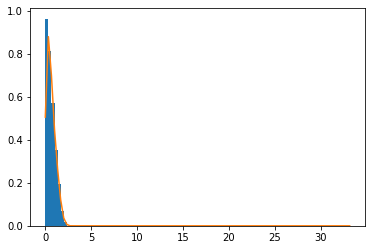

Histogram for F Test feature  2


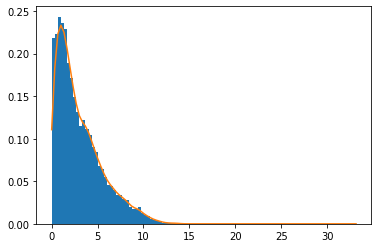

Histogram for F Test feature  3


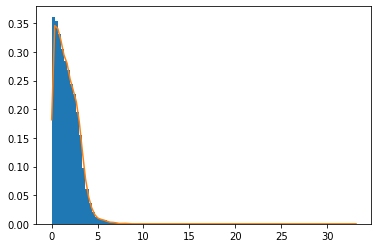

Histogram for F Test feature  4


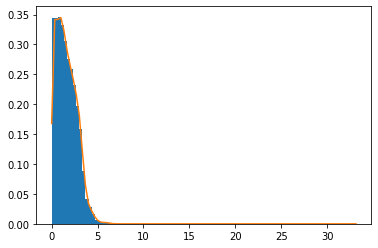

Histogram for F Test feature  5


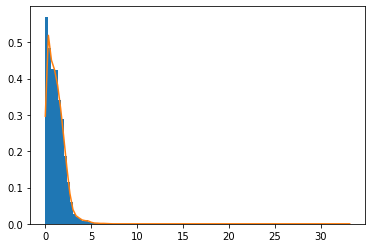

Histogram for F Test feature  6


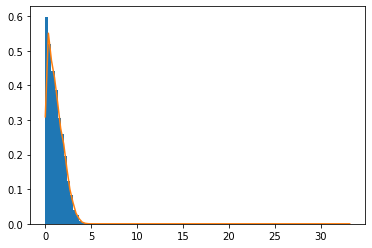

Histogram for F Test feature  7


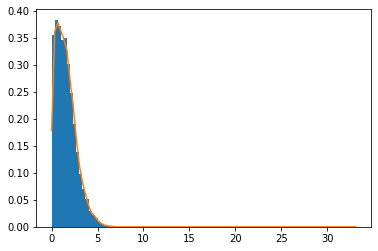

Histogram for F Test feature  8


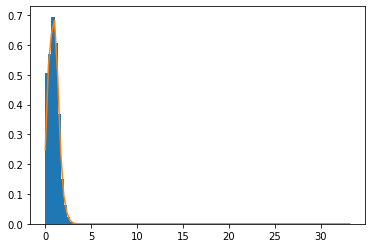

Histogram for F Test feature  9


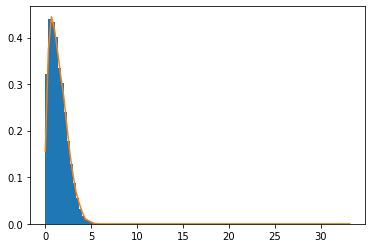

Printing the shape of the input!
torch.Size([40000, 10])
Printing the shape of the target!
torch.Size([40000, 1])
LR Accuracy within training data - All features :  0.970925


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR Accuracy on test data - All features:  0.7876
Accuracy for without feature  0
Logistic Regression Accuracy within training data:  0.962625
Logistic Regression Accuracy on test data:  0.8331
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97095
Logistic Regression Accuracy on test data:  0.7864
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97105
Logistic Regression Accuracy on test data:  0.78895
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.948875
Logistic Regression Accuracy on test data:  0.4949
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.939725
Logistic Regression Accuracy on test data:  0.3767
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.97075
Logistic Regression Accuracy on test data:  0.78555
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.966475
Logistic Regression Accuracy on test data:  0.73315
Accuracy for without feature  7
Logistic Regression Accuracy within training data:  0.9658
Logistic Regression Accuracy on test data:  0.7399
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Accuracy within training data:  0.9694
Logistic Regression Accuracy on test data:  0.7623
Accuracy for without feature  9
Logistic Regression Accuracy within training data:  0.970575
Logistic Regression Accuracy on test data:  0.7886


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
# Computing M
lamdas = [10,9,8,7,6,5,4,3,2,1,0.1,0.01,0.001,0.0001,0.00001,0.000001,0.0000001,0.00000001,0.000000001,0.0000000001]

for lamda in lamdas:
    print()
    print()
    print()
    print()
    print("Results for lamda ", lamda)
    print()
    k = int(Z.shape[1]*0.2) # 20% of original number of features
    n = Z.shape[0]
    delta_Z_matrix = np.absolute((Z[:int(len(color)/2),:] - Z[int(len(color)/2):,:]))
    M = - Z.T @ Z/n + lamda * delta_Z_matrix.T @ delta_Z_matrix / (n // 2 ) 


    # Computing the term on which we perform SVD
    alpha_alpha_T = color_coefficients @ color_coefficients.T
    d = alpha_alpha_T.shape[0]
    I = np.identity(d)
    I_minus_alpa_alpha_T = I-alpha_alpha_T
    term_for_SVD = (I_minus_alpa_alpha_T @ M) @ I_minus_alpa_alpha_T


    # Performing SVD to get eigenvectors and eigenvalues
    from numpy import linalg as LA
    eigenvalues, eigenvectors = LA.eigh(term_for_SVD)
    display(eigenvalues)
    display(eigenvectors)

    # Forming L from eigenvectors and alpha
    L_1 = color_coefficients
    least_k_eigen_values = eigenvalues[:k]
    least_k_eigen_values[np.absolute(least_k_eigen_values)<0.000001]=0

    print("Printing least k eigenvalues before removing the zero eigenvalue")
    print(least_k_eigen_values)

    non_zero_indeces = None
    if 0 in least_k_eigen_values:
        non_zero_indeces = np.nonzero(least_k_eigen_values)[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[non_zero_indeces]
        print("Printing least k-1 eigenvalues after removing the zero eigenvalue")
        print(least_k_eigen_values_without_0)

    else:
        non_zero_indeces = np.nonzero(least_k_eigen_values[:k-1])[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[:k-1]
        print("Printing least k-1 eigenvalues after removing the zero eigenvalue")
        print(least_k_eigen_values_without_0)

    print("Printing non zero indeces of the least k-1 eigenvalues") 
    print(non_zero_indeces) #

    L_2 = eigenvectors[:,non_zero_indeces]

    # print(L_2.shape)

    L = np.concatenate((L_1, L_2), axis=1)

    # print(L.shape)




    # Obtaining F_test values from extracted image features using numpy's linalg.lstsq function.
    F = torch.from_numpy(np.linalg.lstsq(L, Z.transpose(), rcond=None)[0].transpose())
    F_test = torch.from_numpy(np.linalg.lstsq(L, Z_test.transpose(), rcond=None)[0].transpose())
    F_test_green = torch.from_numpy(np.linalg.lstsq(L, Z_test_green.transpose(), rcond=None)[0].transpose())
    F_test_red = torch.from_numpy(np.linalg.lstsq(L, Z_test_red.transpose(), rcond=None)[0].transpose())

    F_envs_1_and_2 = torch.from_numpy(np.linalg.lstsq(L, Z_envs_1_and_2.transpose(), rcond=None)[0].transpose())
    F_env3 = torch.from_numpy(np.linalg.lstsq(L, Z_env3.transpose(), rcond=None)[0].transpose())


    # Plot histograms

    # the difference between F_test_green and F_test_red
    delta_matrix = np.absolute(F_test_green.detach().numpy() - F_test_red.detach().numpy())

    print("Printing the delta matrix")
    delta_matrix_df = pd.DataFrame(delta_matrix)
    display(delta_matrix_df.head())

    # Plotting the histograms for each feature in the delta matrix # 100 bins
    for i in range(len(delta_matrix_df.columns)): 
        print("Histogram for F Test feature ", i)    
        feature = delta_matrix_df.iloc[:,i].values
        density = stats.gaussian_kde(feature)
        n, x, _ = plt.hist(feature, bins=np.linspace(0, np.amax(delta_matrix_df.iloc[:,0]), 100), 
                           histtype='bar', density=True)  
        plt.plot(x, density(x))
        plt.show()
        
                
    
    
    
    # Predicting label when trained on all F_envs_1_and_2 and tested on all F_env3 features including 
    # color - Environment Shift Present - Logistic Regression
    # Using sklearn Logistic Regression
    from sklearn.linear_model import LogisticRegression

    import torch
    from sklearn import preprocessing



    train_data_path = train_extracted_features_df
    test_data_path = test_extracted_features_df


    def read_data(path):
        data_df = path.to_numpy()

        targets = data_df[:, -1] 
        X = data_df[:, :-1] 

        # Standardize the data
        sscaler = preprocessing.StandardScaler()
        sscaler.fit(X)
        X = sscaler.transform(X)


        X_torch = torch.from_numpy(X)
        targets_torch = torch.from_numpy(targets)
        return X_torch, targets_torch



    _, targets_torch_train = read_data(train_data_path)
    _, targets_torch_test = read_data(test_data_path)


    X_torch_train = F_envs_1_and_2
    X_torch_test = F_env3
    X_torch_test_within = F_envs_1_and_2

    targets_torch_train = targets_torch_train.reshape(-1,1)
    targets_torch_test = targets_torch_test.reshape(-1,1)
    targets_torch_test_within = targets_torch_train.reshape(-1,1)


    print("Printing the shape of the input!")
    print(X_torch_train.shape)

    print("Printing the shape of the target!")
    print(targets_torch_train.shape)


    logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train.detach().numpy(), targets_torch_train.numpy())

    print('LR Accuracy within training data - All features : ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_torch_test_within.numpy()))
    print('LR Accuracy on test data - All features: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_torch_test.numpy()))

    
    


    # Predicting label when trained on all F_envs_1_and_2 and tested on all F_env3 features except 
    # color - Environment Shift Present - Logistic Regression

    # Using sklearn Logistic Regression
    from sklearn.linear_model import LogisticRegression

    import torch
    from sklearn import preprocessing

    train_data_path = train_extracted_features_df
    test_data_path = test_extracted_features_df


    def read_data(path):
        data_df = path.to_numpy()

        targets = data_df[:, -1] 
        X = data_df[:, :-1] 

        # Standardize the data
        sscaler = preprocessing.StandardScaler()
        sscaler.fit(X)
        X = sscaler.transform(X)


        X_torch = torch.from_numpy(X)
        targets_torch = torch.from_numpy(targets)
        return X_torch, targets_torch



    _, targets_torch_train = read_data(train_data_path)
    _, targets_torch_test = read_data(test_data_path)


    targets_torch_train = targets_torch_train.reshape(-1,1)
    targets_torch_test = targets_torch_test.reshape(-1,1)
    targets_torch_test_within = targets_torch_train.reshape(-1,1)

    for i in range(F_envs_1_and_2.detach().numpy().shape[1]):
        print("Accuracy for without feature ",i)

        X_torch_train = F_envs_1_and_2.detach().numpy().copy()
        X_torch_test = F_env3.detach().numpy().copy()
        X_torch_test_within = F_envs_1_and_2.detach().numpy().copy()

        X_torch_train = np.delete(X_torch_train, i, 1)
        X_torch_test = np.delete(X_torch_test, i, 1)
        X_torch_test_within = np.delete(X_torch_test_within, i, 1)


        logistic_regression_model = LogisticRegression(random_state=0).fit(X_torch_train, targets_torch_train.numpy())

        print('Logistic Regression Accuracy within training data: ',logistic_regression_model.score(X_torch_test_within, targets_torch_test_within.numpy()))
        print('Logistic Regression Accuracy on test data: ', logistic_regression_model.score(X_torch_test, targets_torch_test.numpy()))




